# Objective
## The scope of this notebook is applying the **Tfidf vectorization** to the set of **normalized sessions**. 

### (This will be helpful to find **similarities** between session)

# Libraries

In [1]:
# Handling data
import pandas as pd
import numpy as np
import json
import random
import re
import math
# System and prints
import os
from tqdm import tqdm
import copy
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
# Plotting
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Input files

#### Setting seed

In [2]:
MY_SEED = 33
random.seed(MY_SEED)

#### Load the JSON dictionary

In [3]:
DIR = "../Data/commands_per_statement/"

#For dataset, contact matteo.boffa@polito.it or idilio.drago@unito.it
file_to_analyze = "readAbove.txt"

agent = file_to_analyze.split(".")[0]
FLAG = False
PARAMS = False
SORT = True
MIN_DF = False
EXECUTABLES = False
with open(DIR+file_to_analyze) as input_file:
    json_sessions = json.load(input_file)

#### Define output dir:

In [4]:
sub_folders = ["Files/", "Imgs/"]
output_folder = f"../Results_clustering/{agent}/Tfidf/Flags_{FLAG}/Executables_{EXECUTABLES}/Min_df_{MIN_DF}/"
for sub_folder in sub_folders:
    os.makedirs(output_folder+sub_folder, exist_ok=True)

### Create the Pandas Dataframe with it

In [5]:
df_sessions = pd.DataFrame.from_dict(json_sessions, orient = 'index').rename_axis('full_sessions').reset_index()

In [6]:
df_sessions.head()

,full_sessions,occurrences,belonging_sessions,sub_tokens
0,"""/bin/busybox ZUOWM""; busybox; tftp; wget; /bi...",1,['2ec62c6d8796'],"[[[/bin/busybox ZUOWM, command]], [[busybox, c..."
1,/etc/init.d/iptables stop; wget http://104.244...,1,['a0c66674c35b'],"[[[/etc/init.d/iptables, command], [stop, para..."
2,/etc/init.d/iptables stop;service iptables sto...,20,"['040e9b4ef7dc', '1999016a574c', '1e1dfdd9cd92...","[[[/etc/init.d/iptables, command], [stop, para..."
3,/etc/init.d/iptables stop;service iptables sto...,8,"['04b94dad65d1', '3480e2aef6bb', '80a7432c6f25...","[[[/etc/init.d/iptables, command], [stop, para..."
4,/etc/init.d/iptables stop;service iptables sto...,1,['266180a716b4'],"[[[/etc/init.d/iptables, command], [stop, para..."


## Plot some stats on occurrences sessions

#### CDF

In [7]:
sorted_df_sessions = df_sessions.sort_values(by = ["occurrences"])
cdf = sorted_df_sessions.value_counts("occurrences").sort_index()
cdf = np.cumsum(cdf)/np.sum(cdf)

#### PDF

In [8]:
occurrences = sorted_df_sessions["occurrences"].values

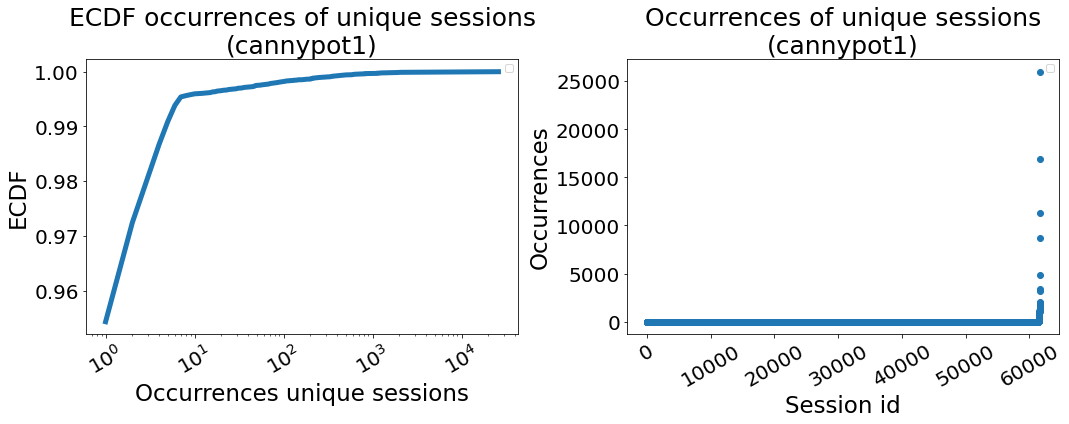

In [9]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
fontsize = 20
axs[0].plot(cdf.reset_index().occurrences, cdf.reset_index()[0], linewidth = 5)
axs[0].set_title(f'ECDF occurrences of unique sessions\n({agent})', fontsize = fontsize + 5)
axs[0].set_ylabel('ECDF', fontsize = fontsize + 3)
axs[0].set_xlabel('Occurrences unique sessions', fontsize = fontsize + 3)
axs[0].set_xscale("log")

axs[1].scatter(np.arange(occurrences.shape[0]), occurrences)
axs[1].set_title(f'Occurrences of unique sessions\n({agent})', fontsize = fontsize + 5)
axs[1].set_ylabel('Occurrences', fontsize = fontsize + 3)
axs[1].set_xlabel('Session id', fontsize = fontsize + 3)
#axs[1].set_xticks([])
#axs[1].set_yscale("log")

for it, ax in enumerate(axs):
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)      
    ax.legend([])
    
plt.tight_layout()
plt.savefig(output_folder+sub_folders[1]+"Unique_sessions_stats.png")
plt.show()

#### Sessions normalizing function

In [10]:
def normalize_session(session_statements, flags = False, params = False, sort = False, executables = False):
    s = []
    # Each session has a series of statements   
    for statement in session_statements:
        #Each statement has multiple components (i.e. command + flag + param)
        for sub_component in statement:
            if sub_component[1] == "param":
                if params:
                    s.append(sub_component[0].strip())
            elif sub_component[1] == "flag" or sub_component[1] == "redirect":
                if flags:
                    s.append(sub_component[0].strip())
            else:
                if not executables:
                    if "./" == sub_component[0].strip()[:2]:
                        s.append('./EXEC')
                    elif len(sub_component[0].split("/")) != 1:
                        s.append(sub_component[0].split("/")[-1].strip())
                        
                    elif "Enter" != sub_component[0].strip():
                        if sub_component[0].strip()[-1] == ":":
                            s.append(sub_component[0].strip()[:-1])
                        elif sub_component[0].strip() == "LC_ALL=en_US.UTF-8":
                            s.append("bash")
                        else:
                            s.append(sub_component[0].strip())
                else:
                    s.append(sub_component[0].strip())
    if sort:
        s.sort()
    # Goal is to return the full normalized session as a string
    return '; '.join(map(str, s))

#### Normalize

In [11]:
df_normalized_sessions = df_sessions.copy()
# Notice: since the alternatives to vectorize strings are order-independent, I can sort them to avoid duplicates
df_normalized_sessions["sub_tokens"] = df_normalized_sessions["sub_tokens"].map(lambda x: normalize_session(x, sort = SORT, flags = FLAG, params = PARAMS, executables = EXECUTABLES))
df_normalized_sessions.rename(columns={"sub_tokens":"normalized_sessions"}, inplace = True)
df_normalized_sessions.head()

,full_sessions,occurrences,belonging_sessions,normalized_sessions
0,"""/bin/busybox ZUOWM""; busybox; tftp; wget; /bi...",1,['2ec62c6d8796'],busybox; busybox; busybox; busybox ZUOWM; cat;...
1,/etc/init.d/iptables stop; wget http://104.244...,1,['a0c66674c35b'],iptables; wget
2,/etc/init.d/iptables stop;service iptables sto...,20,"['040e9b4ef7dc', '1999016a574c', '1e1dfdd9cd92...",./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...
3,/etc/init.d/iptables stop;service iptables sto...,8,"['04b94dad65d1', '3480e2aef6bb', '80a7432c6f25...",./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...
4,/etc/init.d/iptables stop;service iptables sto...,1,['266180a716b4'],./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...


#### Notice that we also have a column named "occurrences" since we might want to keep track of how many times we've seen the same session

In [12]:
occurrences_normalized_sessions = df_normalized_sessions.groupby("normalized_sessions")["occurrences"].apply(sum).reset_index()
sorted_df = occurrences_normalized_sessions.sort_values(by=['occurrences'], ascending = False)
sorted_df.head()

,normalized_sessions,occurrences
108,awk; awk; bash; cat; cat; cat; cd; cd; chmod; ...,49699
258,echo,26050
228,cd; cd; cd; cd; cd; chmod; chmod; chmod; curl;...,22396
191,cat; curl; free; ps; sh; sh; uname; wget,13501
38,./EXEC; cd; cd; chmod; curl; history; killall;...,8724


## Plot stats about normalized sessions

#### CDF and PDF

In [13]:
sorted_df = occurrences_normalized_sessions.sort_values(by = ["occurrences"])
cdf = sorted_df.value_counts("occurrences").sort_index()
cdf = np.cumsum(cdf)/np.sum(cdf)
occurrences = sorted_df["occurrences"].values

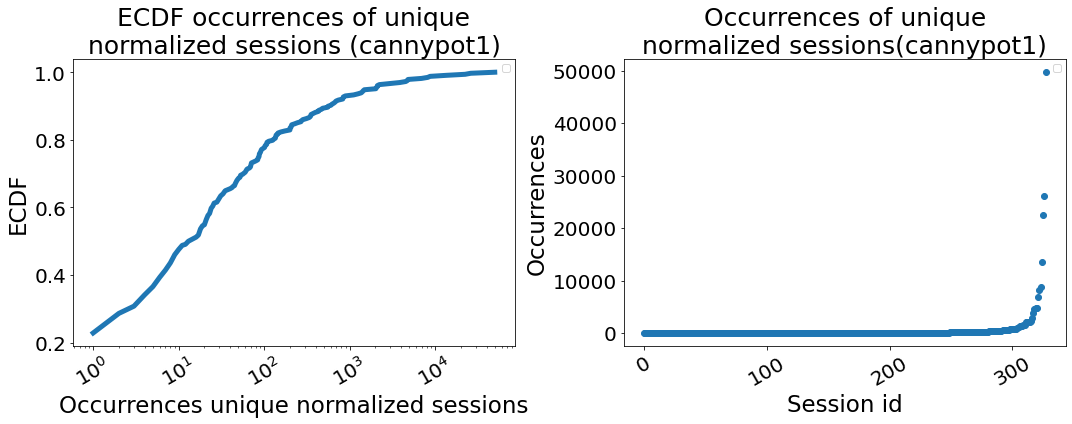

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
fontsize = 20
axs[0].plot(cdf.reset_index().occurrences, cdf.reset_index()[0], linewidth = 5)
axs[0].set_title(f'ECDF occurrences of unique\nnormalized sessions ({agent})', fontsize = fontsize + 5)
axs[0].set_ylabel('ECDF', fontsize = fontsize + 3)
axs[0].set_xlabel('Occurrences unique normalized sessions', fontsize = fontsize + 3)
axs[0].set_xscale("log")

axs[1].scatter(np.arange(occurrences.shape[0]), occurrences)
axs[1].set_title(f'Occurrences of unique\nnormalized sessions({agent})', fontsize = fontsize + 5)
axs[1].set_ylabel('Occurrences', fontsize = fontsize + 3)
axs[1].set_xlabel('Session id', fontsize = fontsize + 3)
#axs[1].set_xticks([])
#axs[1].set_yscale("log")

for it, ax in enumerate(axs):
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)      
    ax.legend([])
    
plt.tight_layout()
plt.savefig(output_folder+sub_folders[1]+"Normalized_sessions_stats.png")
plt.show()

# Some numerical stats

#### Notice: Normalizing the sessions we further reduced the number of unique items
#### Some of them were might have been different only because different flags or parameters
N.b: in the case of TFIDF, we also lose information about samples' order

In [15]:
print(f"Total number of sessions (with repetitions): {df_normalized_sessions['occurrences'].sum()}")
print(f"Number of distinct sessions: {df_normalized_sessions.shape[0]}")
print(f"Number of normalized distinct sessions: {df_normalized_sessions['normalized_sessions'].nunique()}")

Total number of sessions (with repetitions): 196795
Number of distinct sessions: 61594
Number of normalized distinct sessions: 328


# Tfidf

## First we want to tune the parameters (min_df)

The formula that is used to compute the tf-idf for a term t of a document d in a document set is:

- tf-idf(t, d) = tf(t, d) * idf(t)

and the idf is computed as:

- idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False)

If smooth_idf=True (the default):

- idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1

N.b. log = ln for sklearn

#### Use Tfidf + tokenizer from Sklearn
The tokenizer is used to "explain" the algorithm how to split the commands of our sessions

In [16]:
def custom_tokenizer(session):
    return [el.strip() for el in session.split("; ")]

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase = False, tokenizer=custom_tokenizer, smooth_idf = True, max_df = 1.0, min_df = 1)
vectors = vectorizer.fit_transform(df_normalized_sessions["normalized_sessions"].drop_duplicates())

#### Recover the idfs

In [18]:
sklearn_tfidf = {}
for key, index in vectorizer.vocabulary_.items():
    sklearn_tfidf[key] = vectorizer.idf_[index]

#### Save idfs in a JSON file

In [19]:
with open(output_folder+sub_folders[0]+'idfs.json', 'w+') as fp:
    json.dump(sklearn_tfidf, fp)

In [20]:
df_idfs_sklearn = pd.DataFrame({'commands':sklearn_tfidf.keys(), 'sklearn_idfs':sklearn_tfidf.values()})
df_idfs_sklearn.sort_values(by = ["sklearn_idfs"], inplace = True)

#### Recover counts of commands presence in sessions

In [21]:
n = df_normalized_sessions['normalized_sessions'].nunique()
def obtain_count_from_idf(idf):
    num = (1+n)
    den = (math.exp(idf-1))
    count = (num/den) - 1
    assert count - round(count) < 1e-05 , f"Error: formula is wrong ({count - round(count)})"
    return count

In [22]:
df_idfs_sklearn["counts"] = df_idfs_sklearn["sklearn_idfs"].apply(obtain_count_from_idf)

#### Obtain PDF and CDF

In [23]:
df_idfs_sklearn["pdf"] = df_idfs_sklearn["counts"].apply(lambda count: count/n)
df_idfs_sklearn['cdf'] = df_idfs_sklearn['pdf'].cumsum()

#### Find knee of distribution > To discover which commands are useful to maintain in the representation

In [24]:
from kneed import KneeLocator
def find_knee(data, interpr = "polynomial", curve = "convex", direction = "increasing"):
    kneedle = KneeLocator(range(1,len(data)+1), data, curve=curve, direction=direction, S = 5) #interp_method=interpr
    return kneedle

In [25]:
kneedle = find_knee(df_idfs_sklearn["pdf"], curve = "convex", interpr = "polynomial", direction = "decreasing")

#### Plot:
- idfs trends
- counts of presence
- pdf distribution of commands + knee of distribution

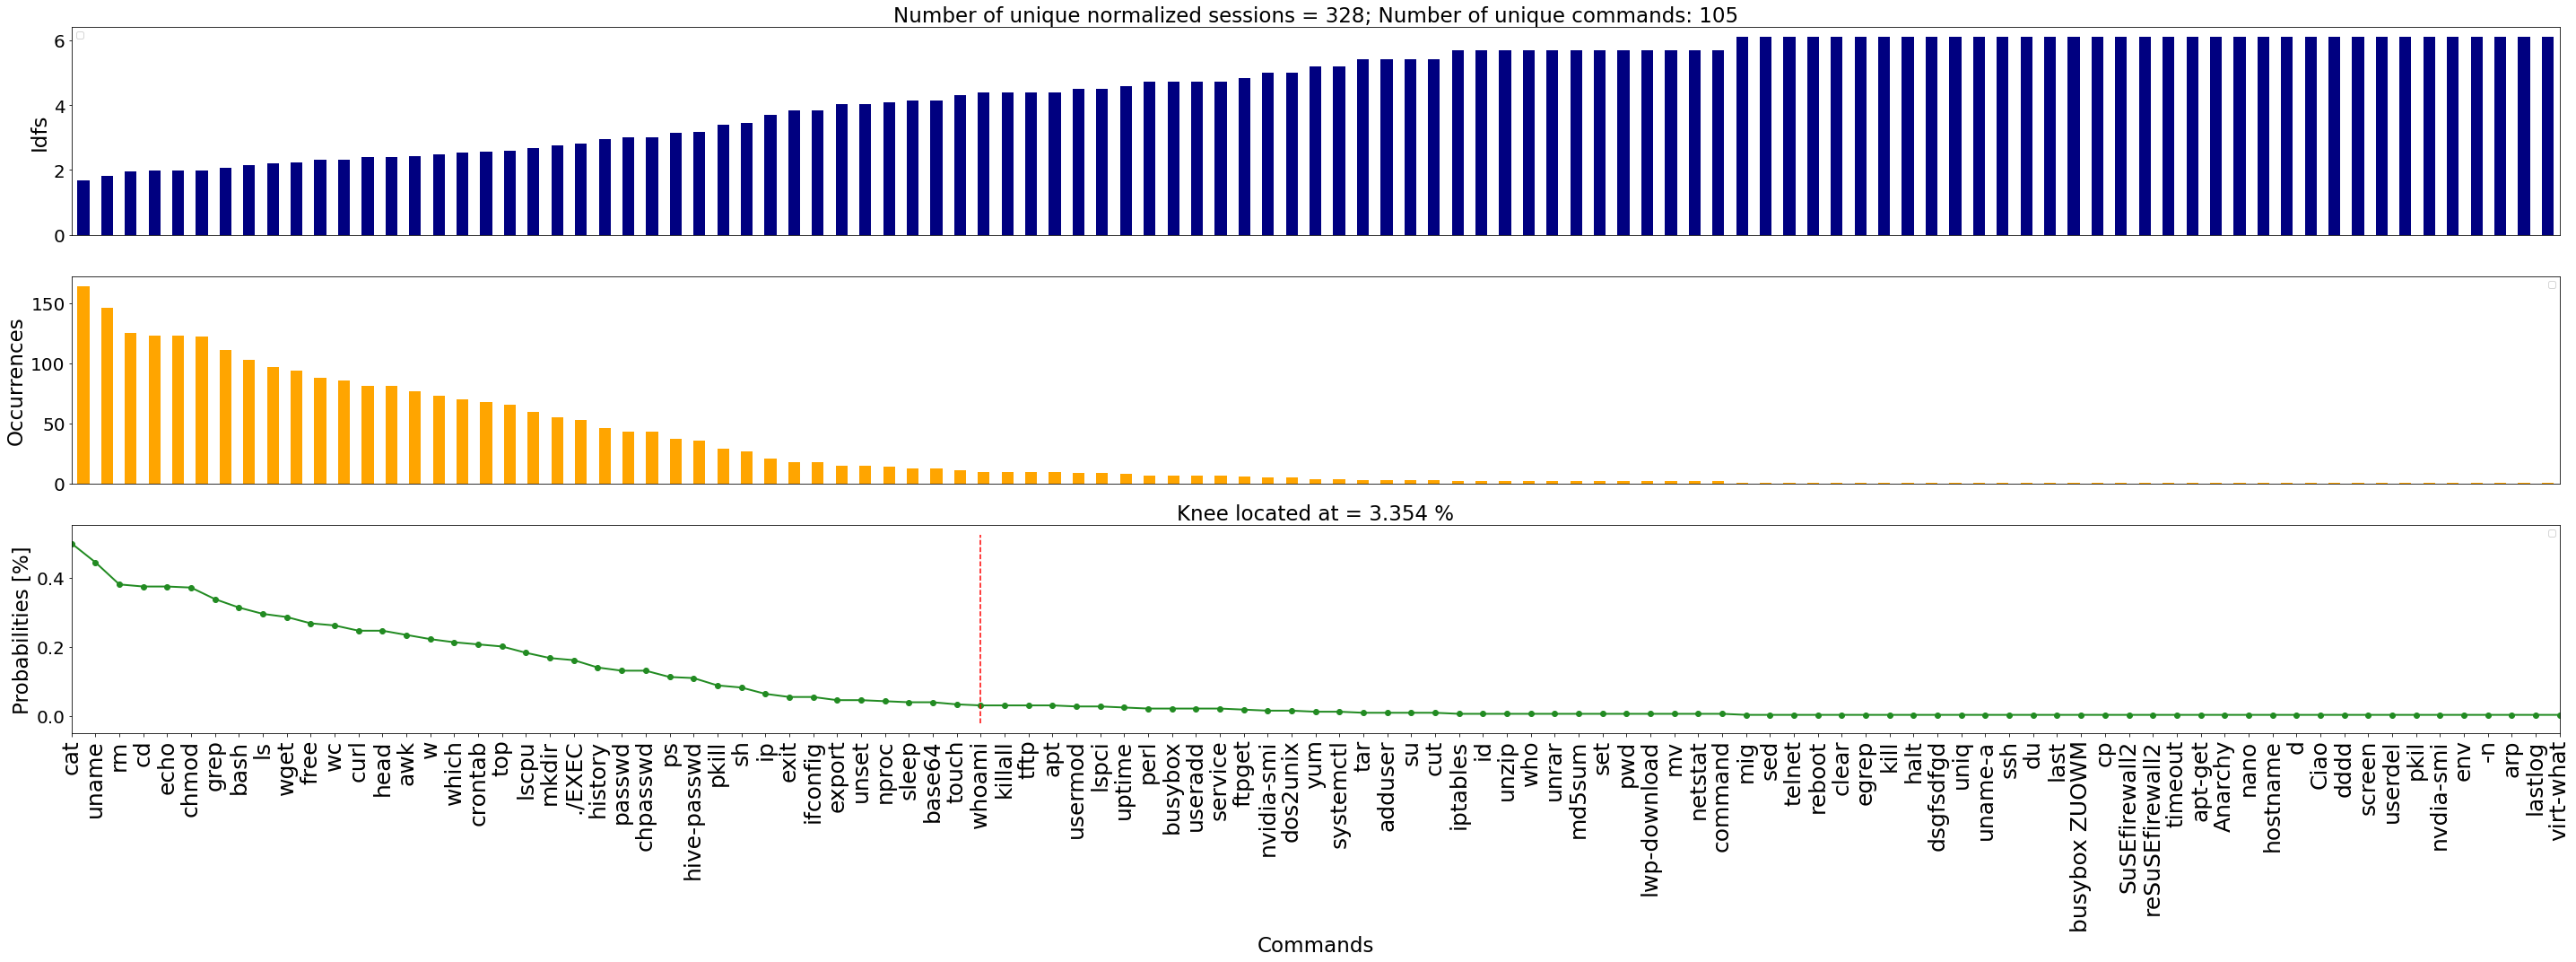

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize =(40, 15))
fontsize = 20
df_idfs_sklearn.plot.bar(x='commands', y='sklearn_idfs', color = "navy", ax = ax1)
df_idfs_sklearn.plot.bar(x='commands', y='counts', color = "orange", ax = ax2)
ax3.plot(list(df_idfs_sklearn["commands"]), list(df_idfs_sklearn["pdf"]), linewidth = 2, color='forestgreen')
ax3.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color = "red")

ax3.scatter(list(df_idfs_sklearn["commands"]),  list(df_idfs_sklearn["pdf"]), color='forestgreen')
#fig.suptitle(f'Idfs, counts, pdf of commands + knee for agent {agent}', fontsize=fontsize+5)
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel('Commands', fontsize = fontsize + 3)
ax3.set_ylabel("Probabilities [%]", fontsize = fontsize + 3)
ax3.set_xlim(0, (list(df_idfs_sklearn["commands"])[-1]))
ax1.set_title(f"Number of unique normalized sessions = {n}; Number of unique commands: {len(list(df_idfs_sklearn['commands']))}", fontsize = fontsize + 3)
ax3.set_title(f"Knee located at = {round((kneedle.knee_y*100),3)} %", fontsize = fontsize + 3)
ax1.set_ylabel('Idfs', fontsize = fontsize + 3)
ax2.set_ylabel('Occurrences', fontsize = fontsize + 3)

for ax in [ax1, ax2, ax3]:
    ax.legend([])
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
for ax in [ax1, ax2]:
    ax.set_xticks([])

ax3.xaxis.set_tick_params(labelsize=fontsize+5, rotation = 90)
    
plt.subplots_adjust(hspace=.2)
plt.tight_layout()
plt.savefig(output_folder+sub_folders[1]+"Tfidf_tuning.png")
plt.show()

## Here we can maintain the min_df from the analysis or simply keep all the commands 

In [27]:
if MIN_DF:
    min_df = df_idfs_sklearn["counts"].iloc[kneedle.knee]
else: 
    min_df = 1

## Now run the tuned algorithm

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase = False, tokenizer=custom_tokenizer, smooth_idf = True, max_df = 1.0, min_df = int(round(min_df)))
vectors = vectorizer.fit_transform(df_normalized_sessions["normalized_sessions"].drop_duplicates())
count_array = vectors.toarray()
df_analysis = pd.DataFrame(count_array, columns=vectorizer.get_feature_names())

In [29]:
print(f"Reduced the number of features to {count_array.shape[1]} (it was {df_idfs_sklearn.shape[0]})")

Reduced the number of features to 105 (it was 105)


# Clustering (Agglomerative clustering)

#### We have to remove rows in which Tfidf did not find any words from the dictionary

In [30]:
zero_rows = np.where(~count_array.any(axis=1))[0] #Indexes corresponding to full-0 rows
count_array_processed = count_array.copy()
count_array_processed = np.delete(count_array_processed, zero_rows, axis = 0)

#### Dunn index definition

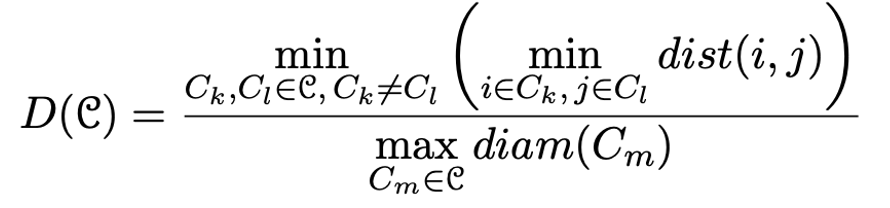

In [31]:
from PIL import Image

image = Image.open("./Dunn_index.png")
display(image)

In [32]:
from sklearn.metrics.pairwise import euclidean_distances
def find_dunn_score(data, labels):
    avg_distances_within = []
    centroids = []
    for k in set(labels):
        cluster_k = data[labels == k]
        centroid = np.mean(cluster_k, axis = 0).reshape(1, -1)
        avg_distance_within = np.mean(euclidean_distances(cluster_k)) 
        avg_distances_within.append(avg_distance_within)
        centroids.append(centroid.reshape(-1)) #Find centroids of each cluster (mean point)

    centroids_pairwise_distances = euclidean_distances(np.array(centroids)) #Find pairwise distances between centroids
    np.fill_diagonal(centroids_pairwise_distances, np.inf) #Mask diagonal
    #numerator = np.min(centroids_pairwise_distances)
    indexes_closest_clusters = np.where(centroids_pairwise_distances == np.min(centroids_pairwise_distances))
    #We will now have 2 lists containing (cluster_1, cluster_2) indices satisfying the query: we want the the first two.
    index_cluster_1, index_cluster_2 = indexes_closest_clusters[0][0], indexes_closest_clusters[1][0]
    cluster_1, cluster_2 = data[labels == index_cluster_1], data[labels == index_cluster_2]
    numerator = np.min(euclidean_distances(cluster_1,cluster_2))
    denominator = np.max(avg_distances_within)
    
    return numerator/denominator, numerator, denominator

#### Tune Agglomerative Clustering + Plot Silhuettes to choose parameters clustering

In [33]:
import sklearn.cluster as clus
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import normalize
from sklearn.metrics import davies_bouldin_score

def save_silhs(silhouettes, cosine_thresholds, max_threshold, max_silh):
    json_dict = {
        "sils": silhouettes,
        "cos_thresholds": cosine_thresholds.tolist(),
        "max_threhshold": max_threshold,
        "best_sil": max_silh
    }
    os.makedirs("../Results_clustering/common/", exist_ok=True)
    with open("../Results_clustering/common/tfidf_silhs.json", 'w+') as fp:
        json.dump(json_dict, fp)

def tune_Agglomerative_Clustering(data, cosine_threshold, output_folder):
    
    euclidean_threshold = np.sqrt(np.multiply(cosine_threshold,2))
    silhouettes=[]
    ch_scores = []
    dunn_scores = []
    sparsities = []
    separations = []
    
    for it, threshold in zip(tqdm(range(len(euclidean_threshold))), euclidean_threshold):
        #clusters=clus.AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=threshold).fit(data)
        clusters=clus.AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=threshold).fit(data)
        lab=clusters.labels_
        if len(set(lab)) == 1:
            print()
            print("#"*23+" Only one cluster was found! "+"#"*23)
            break
        else:
            #sil=silhouette_score(data,lab, metric = "cosine")
            sil=silhouette_score(data,lab)
            ch = calinski_harabasz_score(data,lab)
            dunn, separation, sparsity = find_dunn_score(count_array_processed, lab)
            sparsities.append(sparsity)
            separations.append(separation)
            dunn_scores.append(dunn)
            silhouettes.append(sil)
            ch_scores.append(ch)
    
    kneedle_ch = find_knee(ch_scores, curve = "convex", interpr = "polynomial", direction = "decreasing")
    plot_metrics(silhouettes, ch_scores, dunn_scores, cosine_threshold, 
                 cosine_threshold[np.argmax(silhouettes)], np.max(silhouettes), 
                 cosine_threshold[kneedle_ch.knee], kneedle_ch.knee_y, 
                 cosine_threshold[np.argmax(dunn_scores)], np.max(dunn_scores),
                 sparsities, separations,
                 output_folder)
    
    save_silhs(silhouettes, cosine_threshold, cosine_threshold[np.argmax(silhouettes)], np.max(silhouettes))
    
    return cosine_threshold[np.argmax(silhouettes)], cosine_threshold[kneedle_ch.knee], cosine_threshold[np.argmax(dunn_scores)]

def plot_metrics(silhouette_scores, ch_scores, dunn_scores, K, knee_sil, max_sil, knee_ch, elbow_ch, knee_dunn, min_dunn, dunn_sparsities, dunn_separations, output_folder):
    fig, axs = plt.subplots(2,2,figsize =(20, 10))
    fontsize = 20
    axs[0,0].plot(K, silhouette_scores, linewidth = 2, color='navy')
    axs[0,0].scatter(K, silhouette_scores, color='k')
    axs[0,0].vlines(knee_sil, axs[0,0].get_ylim()[0], axs[0,0].get_ylim()[1], linestyles='dashed')

    axs[0,1].plot(K, ch_scores, linewidth = 2, color='navy')
    axs[0,1].scatter(K, ch_scores, color='k')
    axs[0,1].vlines(knee_ch, axs[0,1].get_ylim()[0], axs[0,1].get_ylim()[1], linestyles='dashed')
    
    axs[1,0].plot(K, dunn_scores, linewidth = 2, color='navy')
    axs[1,0].scatter(K, dunn_scores, color='k')
    axs[1,0].vlines(knee_dunn, axs[1,0].get_ylim()[0], axs[1,0].get_ylim()[1], linestyles='dashed')
    
    axs[1,1].plot(K, dunn_sparsities, linewidth = 2, color='red', label = "Sparsity")
    axs[1,1].scatter(K, dunn_sparsities, color='k')
    axs[1,1].plot(K, dunn_separations, linewidth = 2, color='green', label = "Separation")
    axs[1,1].scatter(K, dunn_separations, color='k')
    
    axs[0,0].set_ylabel('Silhouette score', fontsize = fontsize + 3)
    axs[0,0].set_title(f"Silhouette\n(knee = {round(knee_sil,3)} with Silh score: {round(max_sil, 3)})", fontsize = fontsize + 3)
    axs[0,1].set_ylabel('CH score', fontsize = fontsize + 3)
    axs[0,1].set_title(f"CH score\n(knee = {round(knee_ch,3)} with CH score: {round(elbow_ch, 3)})", fontsize = fontsize + 3)
    axs[1,0].set_ylabel('Dunn score', fontsize = fontsize + 3)
    axs[1,0].set_title(f"Dunn score\n(knee = {round(knee_dunn,3)} with Dunn score: {round(min_dunn, 3)})", fontsize = fontsize + 3)
    axs[1,1].set_ylabel('Euclidean Distance', fontsize = fontsize + 3)
    axs[1,1].set_title(f"Dunn score\nSparsity vs Separation", fontsize = fontsize + 3)
    axs[1,1].legend()
    
    for ax_x in axs:
        for ax in ax_x:
            ax.set_xlabel('Cosine Distance', fontsize = fontsize + 3)
            ax.set_xlim(K[0], K[-1])
            ax.xaxis.set_tick_params(labelsize=fontsize)
            ax.yaxis.set_tick_params(labelsize=fontsize)
    #axs.set_ylim(0,100)
    fig.suptitle(f"Metric's trends", fontsize=fontsize+5)
    plt.tight_layout()
    plt.savefig(output_folder+"Clustering_Tuning.png")
    plt.show() 

## Tuning phase (Agglomerative clustering requires number of clusters or *minimum joining distance*)

#### Tune with Silhouette

In [34]:
def euclidean_2_cosine(el):
    return el**2/2

In [35]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(count_array_processed, method='average', metric='euclidean')

In [36]:
cosine_threshold = np.array(list(map(euclidean_2_cosine, Z[10:, 2])))

100%|██████████| 317/317 [00:21<00:00, 15.09it/s]


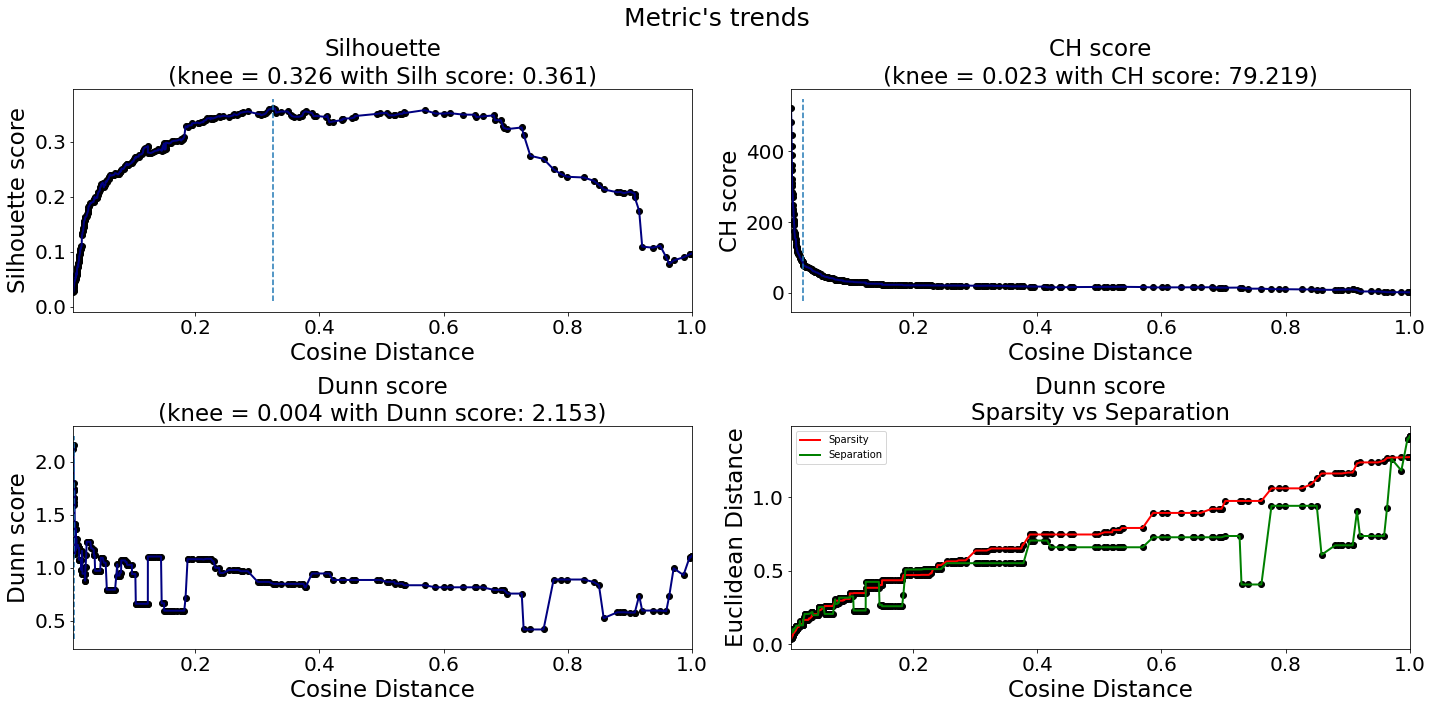


Therefore we chose: 
	-cosine_threshold_sil = 0.326
	-cosine_threshold_ch = 0.023
	-cosine_threshold_dunn = 0.004


In [37]:
#cosine_threshold = np.arange(.1, .9, .01)
best_cosine_threshold_sil, best_cosine_threshold_ch, best_cosine_threshold_dunn = tune_Agglomerative_Clustering(count_array_processed, cosine_threshold, output_folder + sub_folders[1])
print(f"\nTherefore we chose: \n\t-cosine_threshold_sil = {best_cosine_threshold_sil:.3f}\n\t-cosine_threshold_ch = {best_cosine_threshold_ch:.3f}\n\t-cosine_threshold_dunn = {best_cosine_threshold_dunn:.3f}")

#### Complete preprocessing

#### Merge info about occurrences and normalized sessions

In [38]:
normalized_sessions_and_occurrences = pd.merge(df_normalized_sessions.drop(["occurrences"], axis = 1), occurrences_normalized_sessions, on = ["normalized_sessions"], how="inner")
normalized_sessions_and_occurrences.head()

,full_sessions,belonging_sessions,normalized_sessions,occurrences
0,"""/bin/busybox ZUOWM""; busybox; tftp; wget; /bi...",['2ec62c6d8796'],busybox; busybox; busybox; busybox ZUOWM; cat;...,1
1,/etc/init.d/iptables stop; wget http://104.244...,['a0c66674c35b'],iptables; wget,1
2,/etc/init.d/iptables stop;service iptables sto...,"['040e9b4ef7dc', '1999016a574c', '1e1dfdd9cd92...",./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...,61
3,/etc/init.d/iptables stop;service iptables sto...,"['04b94dad65d1', '3480e2aef6bb', '80a7432c6f25...",./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...,61
4,/etc/init.d/iptables stop;service iptables sto...,['266180a716b4'],./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...,61


#### Remove row corresponding to void elements

In [39]:
parsed_df = normalized_sessions_and_occurrences[["normalized_sessions", "occurrences"]].drop_duplicates().reset_index().copy()
parsed_df_analysis = df_analysis.reset_index().copy()

parsed_df = parsed_df.drop(zero_rows)
parsed_df_analysis = parsed_df_analysis.drop(zero_rows)
    
parsed_df.drop(["index"], axis = 1, inplace = True)
parsed_df_analysis.drop(["index"], axis = 1, inplace = True)

#### Best run of Clustering algorithm

In [40]:
def best_run(data, best_cosine_threshold):
    
    Z = hierarchy.linkage(data, method='average', metric='euclidean')
    clusters, leaves_clustered, distances= obtain_clusters(Z, best_cosine_threshold, data.shape[0])
    print(f"We created {len(clusters.keys())} macro clusters")
    print(f"Those are grouping {len(leaves_clustered)} leaves")
    missing_leaves = set(np.arange(data.shape[0])).difference(leaves_clustered)
    print(f"{len(missing_leaves)} leaves are missing")
    for missing_leave in missing_leaves:
        clusters[missing_leave] = [missing_leave]
    print(f"Therefore in the end we have {len(clusters.keys())} clusters")
        
    return clusters, Z, distances

def obtain_clusters(Z, distance_threshold, cluster_id):
    clusters = {}
    distances = []
    leaves = []
    times_entered = 0
    for it, row in enumerate(Z):
        join_el_1, join_el_2, distance, numerosity = row[0], row[1], row[2], row[3]
        if distance < distance_threshold:
            to_add = []
            times_entered += 1
            #print(f"Distance {distance} is lower than {distance_threshold}")
            for el in [join_el_1, join_el_2]:
                #print(f"\tConsidering element {el}")
                if el not in clusters.keys():
                    #print("\t\tLeaf: adding to the list")
                    to_add.append(el)
                else:
                    to_add += copy.deepcopy(clusters[el])
                    #print(f"\t\tCluster: it contained those {len(copy.deepcopy(clusters[el]))} elements: {clusters[el]}")
                    clusters.pop(el)
            #print(f"\tNew cluster {cluster_id} is getting those elements: {to_add}\n")
            clusters[cluster_id] = copy.deepcopy(to_add)
            cluster_id += 1
        distances.append(distance)
    #print(f"Entered {times_entered} times")
    for cluster, list_leaves in clusters.items():
        leaves += list_leaves
    
    return clusters, set(leaves), distances

In [41]:
print(f"\nThere are {count_array_processed.shape[0]} elements\n")
#best_cosine_threshold = (best_cosine_threshold_sil + best_cosine_threshold_ch + best_cosine_threshold_dunn) / 3
best_cosine_threshold= best_cosine_threshold_sil
print(f"\n(We are using threshold: {round(best_cosine_threshold,3)})\n")
best_cosine_threshold = np.sqrt(best_cosine_threshold*2)
clusters, linkage_matrix, cosine_distances = best_run(count_array_processed, best_cosine_threshold)


There are 328 elements


(We are using threshold: 0.326)

We created 49 macro clusters
Those are grouping 294 leaves
34 leaves are missing
Therefore in the end we have 83 clusters


## Calculate some stats about points disposition

In [42]:
distance_furthest_points = np.max(euclidean_distances(count_array_processed))
pairwise_distances = euclidean_distances(count_array_processed)
np.fill_diagonal(pairwise_distances, np.inf)
distance_closest_points = np.min(pairwise_distances)
average_distance_between_points = np.mean(euclidean_distances(count_array_processed))
std_distance_between_points = np.std(euclidean_distances(count_array_processed))
print("In Euclidean terms:")
print(f"\tDistance between furthest points: {round(distance_furthest_points,3)}")
print(f"\tDistance between closest points: {round(distance_closest_points,3)}")
print(f"\tAverage distance between points: {round(average_distance_between_points,3)}")
print(f"\tStd distance between points: {round(std_distance_between_points,3)}")

In Euclidean terms:
	Distance between furthest points: 1.414
	Distance between closest points: 0.0
	Average distance between points: 1.275
	Std distance between points: 0.243


In [43]:
pairwise_distances = euclidean_distances(count_array_processed)
pairwise_distances = np.sqrt(pairwise_distances)

distance_furthest_points = (np.max(euclidean_distances(count_array_processed))**2)/2
average_distance_between_points = (np.mean(euclidean_distances(count_array_processed))**2)/2
std_distance_between_points = (np.std(euclidean_distances(count_array_processed))**2)/2
pairwise_distances = euclidean_distances(count_array_processed)
np.fill_diagonal(pairwise_distances, np.inf)
distance_closest_points = (np.min(pairwise_distances)**2)/2
print("In Cosine terms:")
print(f"\tDistance between furthest points: {round(distance_furthest_points,3)}")
print(f"\tDistance between closest points: {round(distance_closest_points,3)}")
print(f"\tAverage distance between points: {round(average_distance_between_points,3)}")
print(f"\tStd distance between points: {round(std_distance_between_points,3)}")

In Cosine terms:
	Distance between furthest points: 1.0
	Distance between closest points: 0.0
	Average distance between points: 0.813
	Std distance between points: 0.03


#### Create look-up table (rename clusters)

In [44]:
look_up_table = {}
for it, key in enumerate(clusters.keys()):
    look_up_table[key] = it

#### Obtain sequential identifiers

In [45]:
labels_sil = []
for cluster, list_elements in clusters.items():
    for el in list_elements:
        labels_sil.append((el, look_up_table[cluster]))
labels_sil.sort(key=lambda x: x[0])
labels_df = pd.DataFrame([el[1] for el in labels_sil], columns = ['Cluster'], index = parsed_df.index) #Remember to add use the same indexes of normalized_sessions' ones

#### Save information about session length

In [46]:
session_len = parsed_df["normalized_sessions"].map(lambda x: len([el.strip() for el in str(x).split("; ")])).rename("commands_per_session")

#### Create output dataframe & Obtain information about clusters numerosity

In [47]:
session_info = pd.concat([parsed_df, session_len], axis = 1)
merged_df = pd.concat([session_info, labels_df, parsed_df_analysis], axis = 1)
cluster_numerosity = merged_df.groupby(["Cluster"]).size().reset_index(name='Distinct_types_per_clusters')
merged_numerosity_df = pd.merge(merged_df, cluster_numerosity, on = ["Cluster"], how="inner")
#Reorder columns 
columns = merged_numerosity_df.columns.tolist()
merged_numerosity_df = merged_numerosity_df[columns[:4]+[columns[-1]]+columns[4:-1]]
merged_numerosity_df.head()

,normalized_sessions,occurrences,commands_per_session,Cluster,Distinct_types_per_clusters,-n,./EXEC,Anarchy,Ciao,SuSEfirewall2,...,userdel,usermod,virt-what,w,wc,wget,which,who,whoami,yum
0,busybox; busybox; busybox; busybox ZUOWM; cat;...,1,10,49,1,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.125210,0.0,0.0,0.0,0.0
1,iptables; wget,1,2,50,1,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.366204,0.0,0.0,0.0,0.0
2,./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...,61,7,51,1,0.0,0.232282,0.0,0.0,0.505009,...,0.0,0.0,0.0,0.0,0.0,0.185538,0.0,0.0,0.0,0.0
3,ip,10,1,23,3,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,ip; uname,1,2,23,3,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## A way of understanding which embedding caused the most issues is looking at the single silhouette scores

In [48]:
from sklearn.metrics import silhouette_samples

In [49]:
new_columns = merged_numerosity_df.columns
silhouettes_vector = silhouette_samples(merged_numerosity_df[new_columns[6:]].values, merged_numerosity_df["Cluster"].values)

## Grouping per Clusters

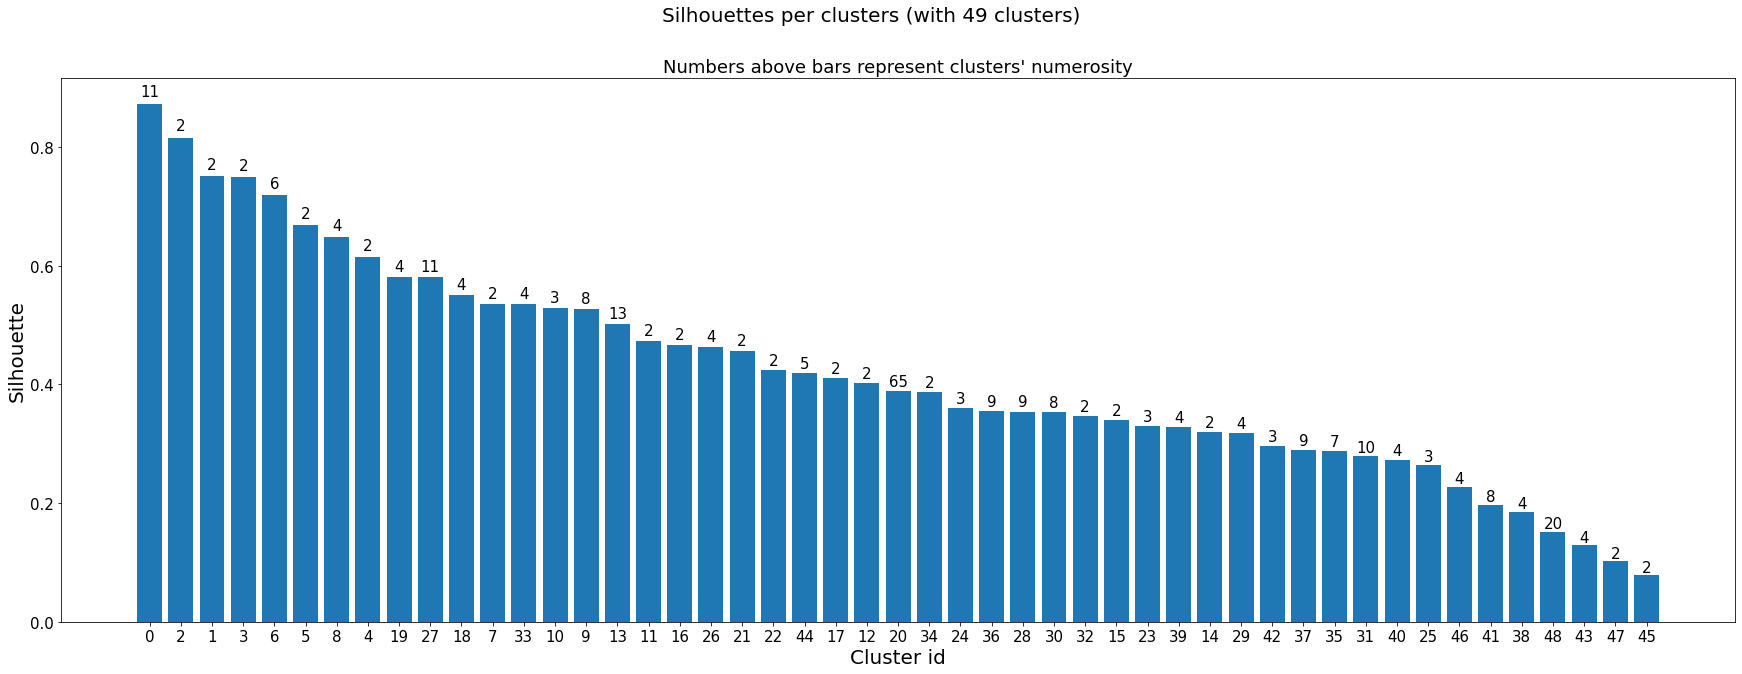

In [50]:
silhouettes = pd.DataFrame({'silhouettes': silhouettes_vector})
silhouette_per_clusters = pd.concat([merged_numerosity_df["Cluster"], silhouettes], axis = 1)
avg_silhouette_per_clusters = silhouette_per_clusters.groupby("Cluster")["silhouettes"].mean().reset_index(name = "avg_silh")
numerosity_clusters = silhouette_per_clusters.groupby("Cluster").size().reset_index(name = "[cluster]")
sil_per_cluster = pd.merge(numerosity_clusters, avg_silhouette_per_clusters, on = ["Cluster"], how="inner").sort_values(by="avg_silh", ascending = False)

sil_per_cluster_filtered = sil_per_cluster[sil_per_cluster["[cluster]"]!=1]

fontsize = 15
figsize = (30, 10)

fig, ax = plt.subplots(figsize = figsize)

bar_x = np.arange(sil_per_cluster_filtered["Cluster"].shape[0])
bar_height = sil_per_cluster_filtered["avg_silh"].values
bar_tick_label = sil_per_cluster_filtered["Cluster"].values
bar_label = sil_per_cluster_filtered["[cluster]"].values

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0, fontsize = fontsize)

autolabel(bar_plot)

ax.set_ylabel('Silhouette', fontsize = fontsize + 5)
ax.set_xlabel('Cluster id', fontsize = fontsize + 5)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)

ax.set_title("Numbers above bars represent clusters' numerosity", fontsize = fontsize + 3)
fig.suptitle(f'Silhouettes per clusters (with {sil_per_cluster_filtered["Cluster"].nunique()} clusters)', fontsize=fontsize+5)

plt.savefig(output_folder+sub_folders[1]+"Silh_per_cluster.png")
plt.show()

## Now we want to add something helping us "visualizing" the relationships between clusters

# TSNE plot

In [51]:
from sklearn.manifold import TSNE
count_array_embedded = TSNE(n_components=2, init='random', metric = "euclidean").fit_transform(count_array_processed)

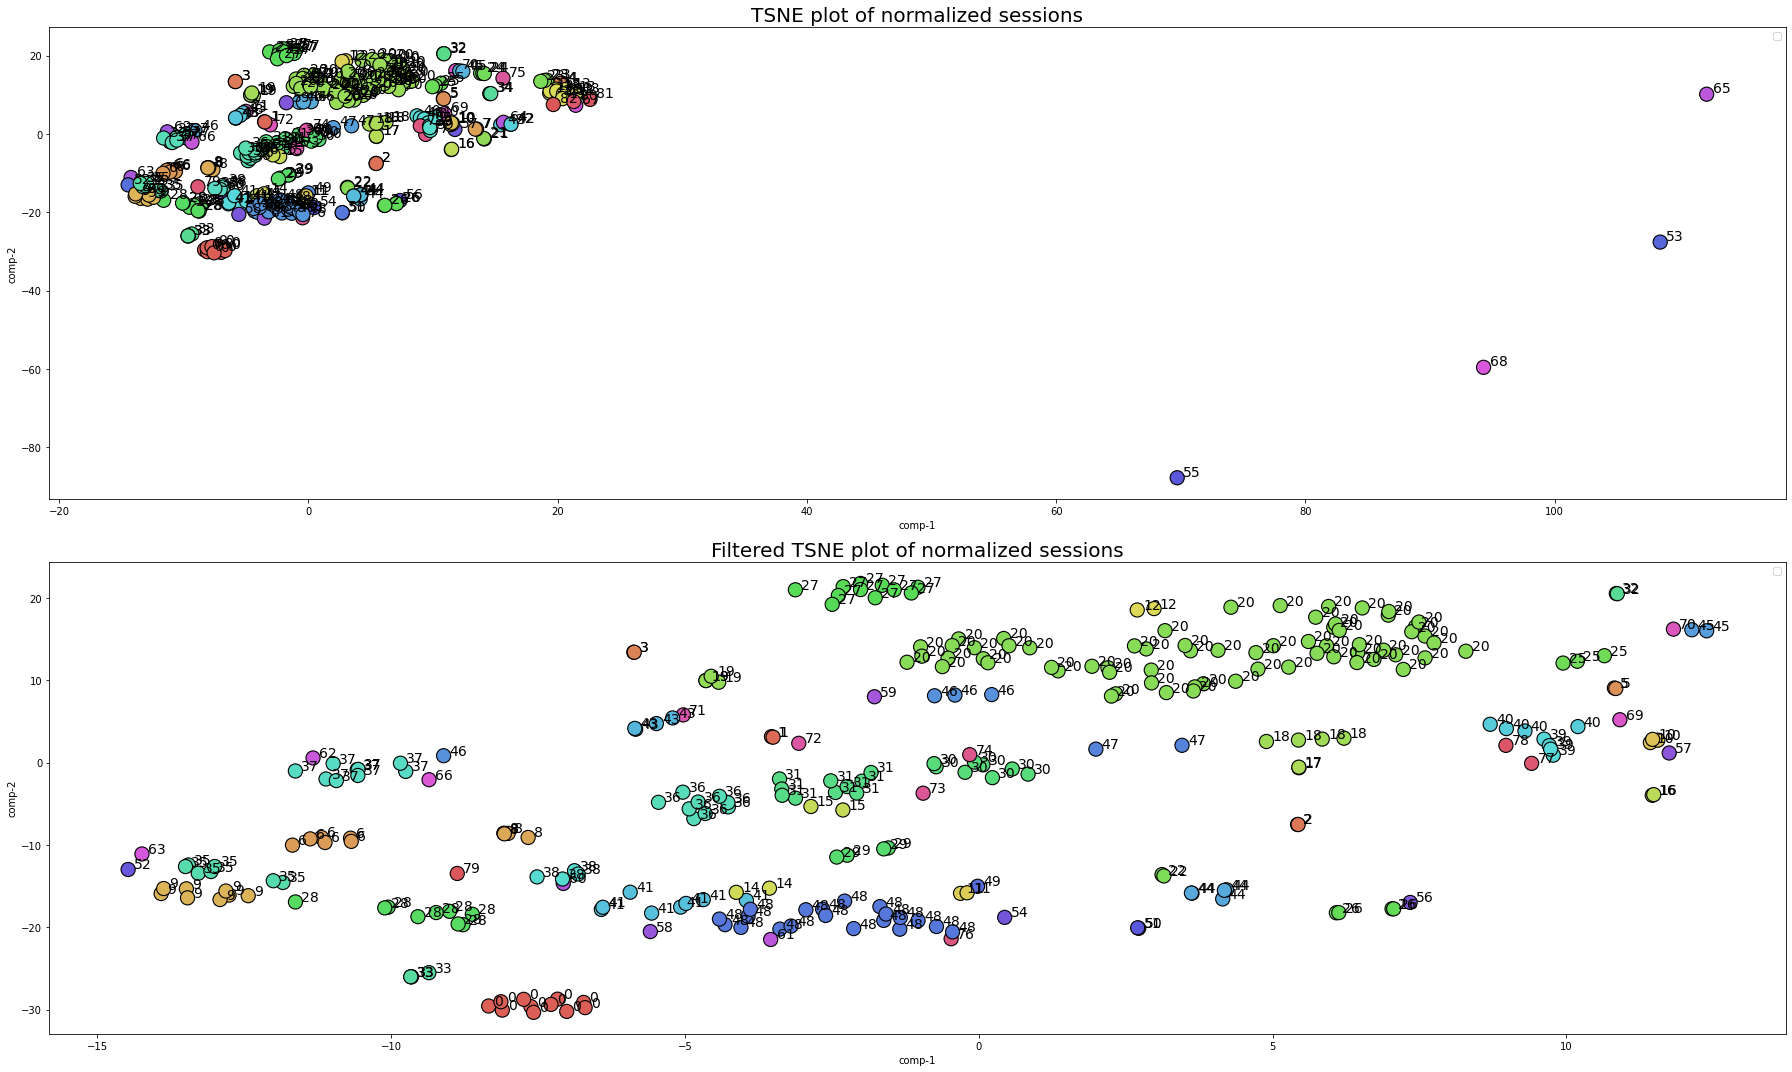

In [52]:
import seaborn as sns

fontsize = 20

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(25,15))

df1 = pd.DataFrame()
df1["y"] = [el[1] for el in labels_sil]
df1["comp-1"] = count_array_embedded[:,0]
df1["comp-2"] = count_array_embedded[:,1]
sns.scatterplot(x="comp-1", y="comp-2", s = 200, hue=df1.y.tolist(), edgecolor = "k",
                palette=sns.color_palette("hls", len(set(df1["y"].values))),
                data=df1, ax=ax1) 
ax1.set_title('TSNE plot of normalized sessions', fontsize = fontsize)

comp1_q1, comp1_q3 = df1["comp-1"].quantile(0.25), df1["comp-1"].quantile(0.75)
comp2_q1, comp2_q3 = df1["comp-2"].quantile(0.25), df1["comp-2"].quantile(0.75)
iqr_comp1, iqr_comp2 = comp1_q3-comp1_q1, comp2_q3-comp2_q1
lower_limit_comp1, upper_limit_comp1 = comp1_q1 - 1.5 * iqr_comp1, comp1_q1 + 1.5 * iqr_comp1
lower_limit_comp2, upper_limit_comp2 = comp2_q1 - 1.5 * iqr_comp2, comp2_q1 + 1.5 * iqr_comp2

df_filtered = df1[df1['comp-1'] < upper_limit_comp1]
df_filtered = df_filtered[df_filtered['comp-1'] > lower_limit_comp1]
df_filtered = df_filtered[df_filtered['comp-2'] < upper_limit_comp2]
df_filtered = df_filtered[df_filtered['comp-2'] > lower_limit_comp2]

ax2.set_title('Filtered TSNE plot of normalized sessions', fontsize = fontsize)
sns.scatterplot(x="comp-1", y="comp-2", s = 200, hue=df_filtered.y.tolist(), edgecolor = "k",
                palette=sns.color_palette("hls", len(set(df_filtered["y"].values))),
                data=df_filtered, ax=ax2) 
ax1.legend([])
ax2.legend([])

for i in range(len(df1["y"].values)):
    xtext, ytext = count_array_embedded[i,0]+.5,count_array_embedded[i,1]+.5
    txt = ax1.text(xtext, ytext, [el[1] for el in labels_sil][i], fontsize=14)

for i in range(len(df_filtered["y"].values)):
    xtext, ytext = df_filtered['comp-1'].values[i]+.1, df_filtered['comp-2'].values[i]+.1
    txt = ax2.text(xtext, ytext, df_filtered["y"].values[i], fontsize=14)

plt.tight_layout()
plt.savefig(output_folder+sub_folders[1]+"TSNE_Plot.png")
plt.show()

## If on the other hand we look at the score per normalized session

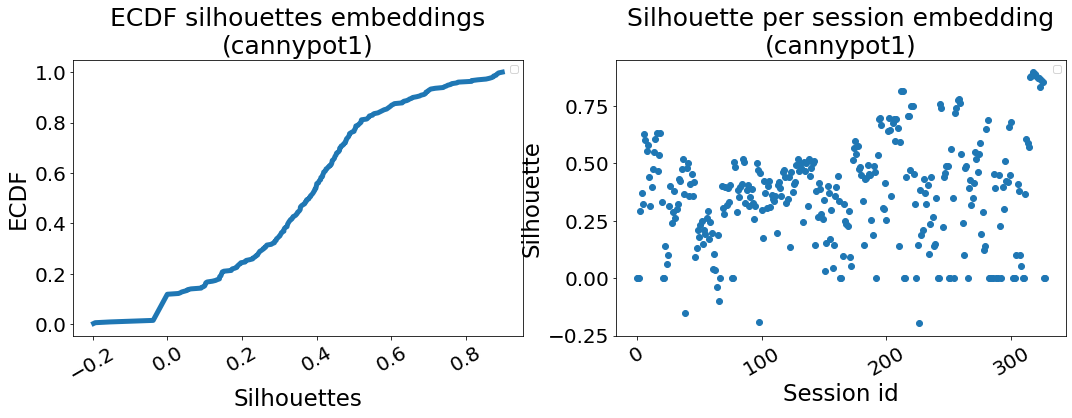

In [53]:
cdf = silhouettes.value_counts("silhouettes").sort_index()
cdf = np.cumsum(cdf)/np.sum(cdf)

fig, axs = plt.subplots(1,2, figsize=(15,6))
fontsize = 20
axs[0].plot(cdf.reset_index().silhouettes, cdf.reset_index()[0], linewidth = 5)
axs[0].set_title(f'ECDF silhouettes embeddings\n({agent})', fontsize = fontsize + 5)
axs[0].set_ylabel('ECDF', fontsize = fontsize + 3)
axs[0].set_xlabel('Silhouettes', fontsize = fontsize + 3)

axs[1].scatter(np.arange(silhouettes.shape[0]), silhouettes['silhouettes'].values)
axs[1].set_title(f'Silhouette per session embedding\n({agent})', fontsize = fontsize + 5)
axs[1].set_ylabel('Silhouette', fontsize = fontsize + 3)
axs[1].set_xlabel('Session id', fontsize = fontsize + 3)

for it, ax in enumerate(axs):
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)      
    ax.legend([])
    
plt.tight_layout()
plt.savefig(output_folder+sub_folders[1]+"Silh_per_sample.png")
plt.show()

#### Most significative commands per clusters

In [54]:
from collections import Counter
merged_numerosity_df["list_commands_session"] = merged_numerosity_df["normalized_sessions"].map(lambda x: [el.strip() for el in str(x).split(";") if el != ""])
sessions_per_cluster = merged_numerosity_df.groupby("Cluster").agg({'list_commands_session': 'sum'}).reset_index()
sessions_per_cluster["count_vectorized"] = sessions_per_cluster["list_commands_session"].apply(lambda x: Counter(x))
sessions_per_cluster["most_representative"] = sessions_per_cluster["count_vectorized"].apply(lambda x: x.most_common(3))

#### Occurrences the cluster has been seen (sum over occurrences of sessions belonging to cluster)

In [55]:
occurrences_per_cluster = merged_numerosity_df.groupby("Cluster")['occurrences'].sum().reset_index()

In [56]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(Z, distance_threshold, look_up_table, clusters, sessions_per_cluster, occurrences_per_cluster, output_folder):
    
    stopping_index = [index for index in range(Z.shape[0]) if Z[index][2] >= distance_threshold][0]

    print(f"\nWe stopped at index {stopping_index}; We miss {Z.shape[0]-stopping_index} merges")

    R = dendrogram(
                Z,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
                no_plot=True,
    )
    
    pattern = "[" + "()" + "]"
    
    temp = {R["leaves"][ii]:(look_up_table[R["leaves"][ii]], sessions_per_cluster.iloc[look_up_table[R["leaves"][ii]]]["most_representative"], 
                             re.sub(pattern, "",  R["ivl"][ii]), occurrences_per_cluster.iloc[look_up_table[R["leaves"][ii]]]["occurrences"]) for ii in range(len(R["leaves"]))}
    
    def llf(x):
        if x < (Z.shape[0]+1):
            return f"Leaf: {look_up_table[x]} - {sessions_per_cluster.iloc[look_up_table[x]]['most_representative']} - Size: {1} - Found: {occurrences_per_cluster.iloc[look_up_table[x]]['occurrences']} times"
        else:
            return "Cluster: {} - {} - Size: {} - Found: {}".format(*temp[x])
    
    plt.xlabel("Cosine distance between nodes", fontsize = fontsize + 3)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    results = dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
        leaf_font_size=14.,
        leaf_label_func=llf,
        show_contracted=True,  # to get a distribution impression in truncated branches  
        orientation = "right"
    )
    
    
    for i, d, c in zip(results['icoord'], results['dcoord'], results['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        plt.plot(y, x, 'o', c=c)
        plt.annotate(f"{round(y**2 /2,3)}", (y, x), xytext=(15, 0),
                             textcoords='offset points',
                             va='center', ha='center', rotation = 270, fontsize = fontsize-8, bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),)
    
    plt.xlim(distance_threshold)
    x_min, x_max = plt.gca().get_xlim()
    x_labels = [round(el,2) for el in np.arange(distance_threshold**2/2, x_max**2/2 + .05, .05)]
    plt.xticks([])
    print(f"Final number of leaves is {len(results['leaves'])}")
    plt.title(f"Hierarchical Clustering Dendrogram (distance threshold: {distance_threshold++2/2:2.3f})", fontsize=fontsize+5)
    fig = plt.gcf()
    fig.set_size_inches(20, 40)
    plt.tight_layout()
    plt.savefig(output_folder+"Dendrogram.png")
    
    
    # Return the info about leaves and clusters
    ordered_leaves = []
    for leaf_id, leaf in enumerate(results["leaves"]):
        if leaf<Z.shape[0]:
             ordered_leaves.append(("Leaf", leaf_id, look_up_table[leaf]))
        else:
            ordered_leaves.append(("Cluster", leaf_id, look_up_table[leaf]))
    ordered_leaves.sort(key = lambda x: x[1], reverse = True)
    return ordered_leaves

#### Plot Dendrogram


We stopped at index 245; We miss 82 merges
Final number of leaves is 83


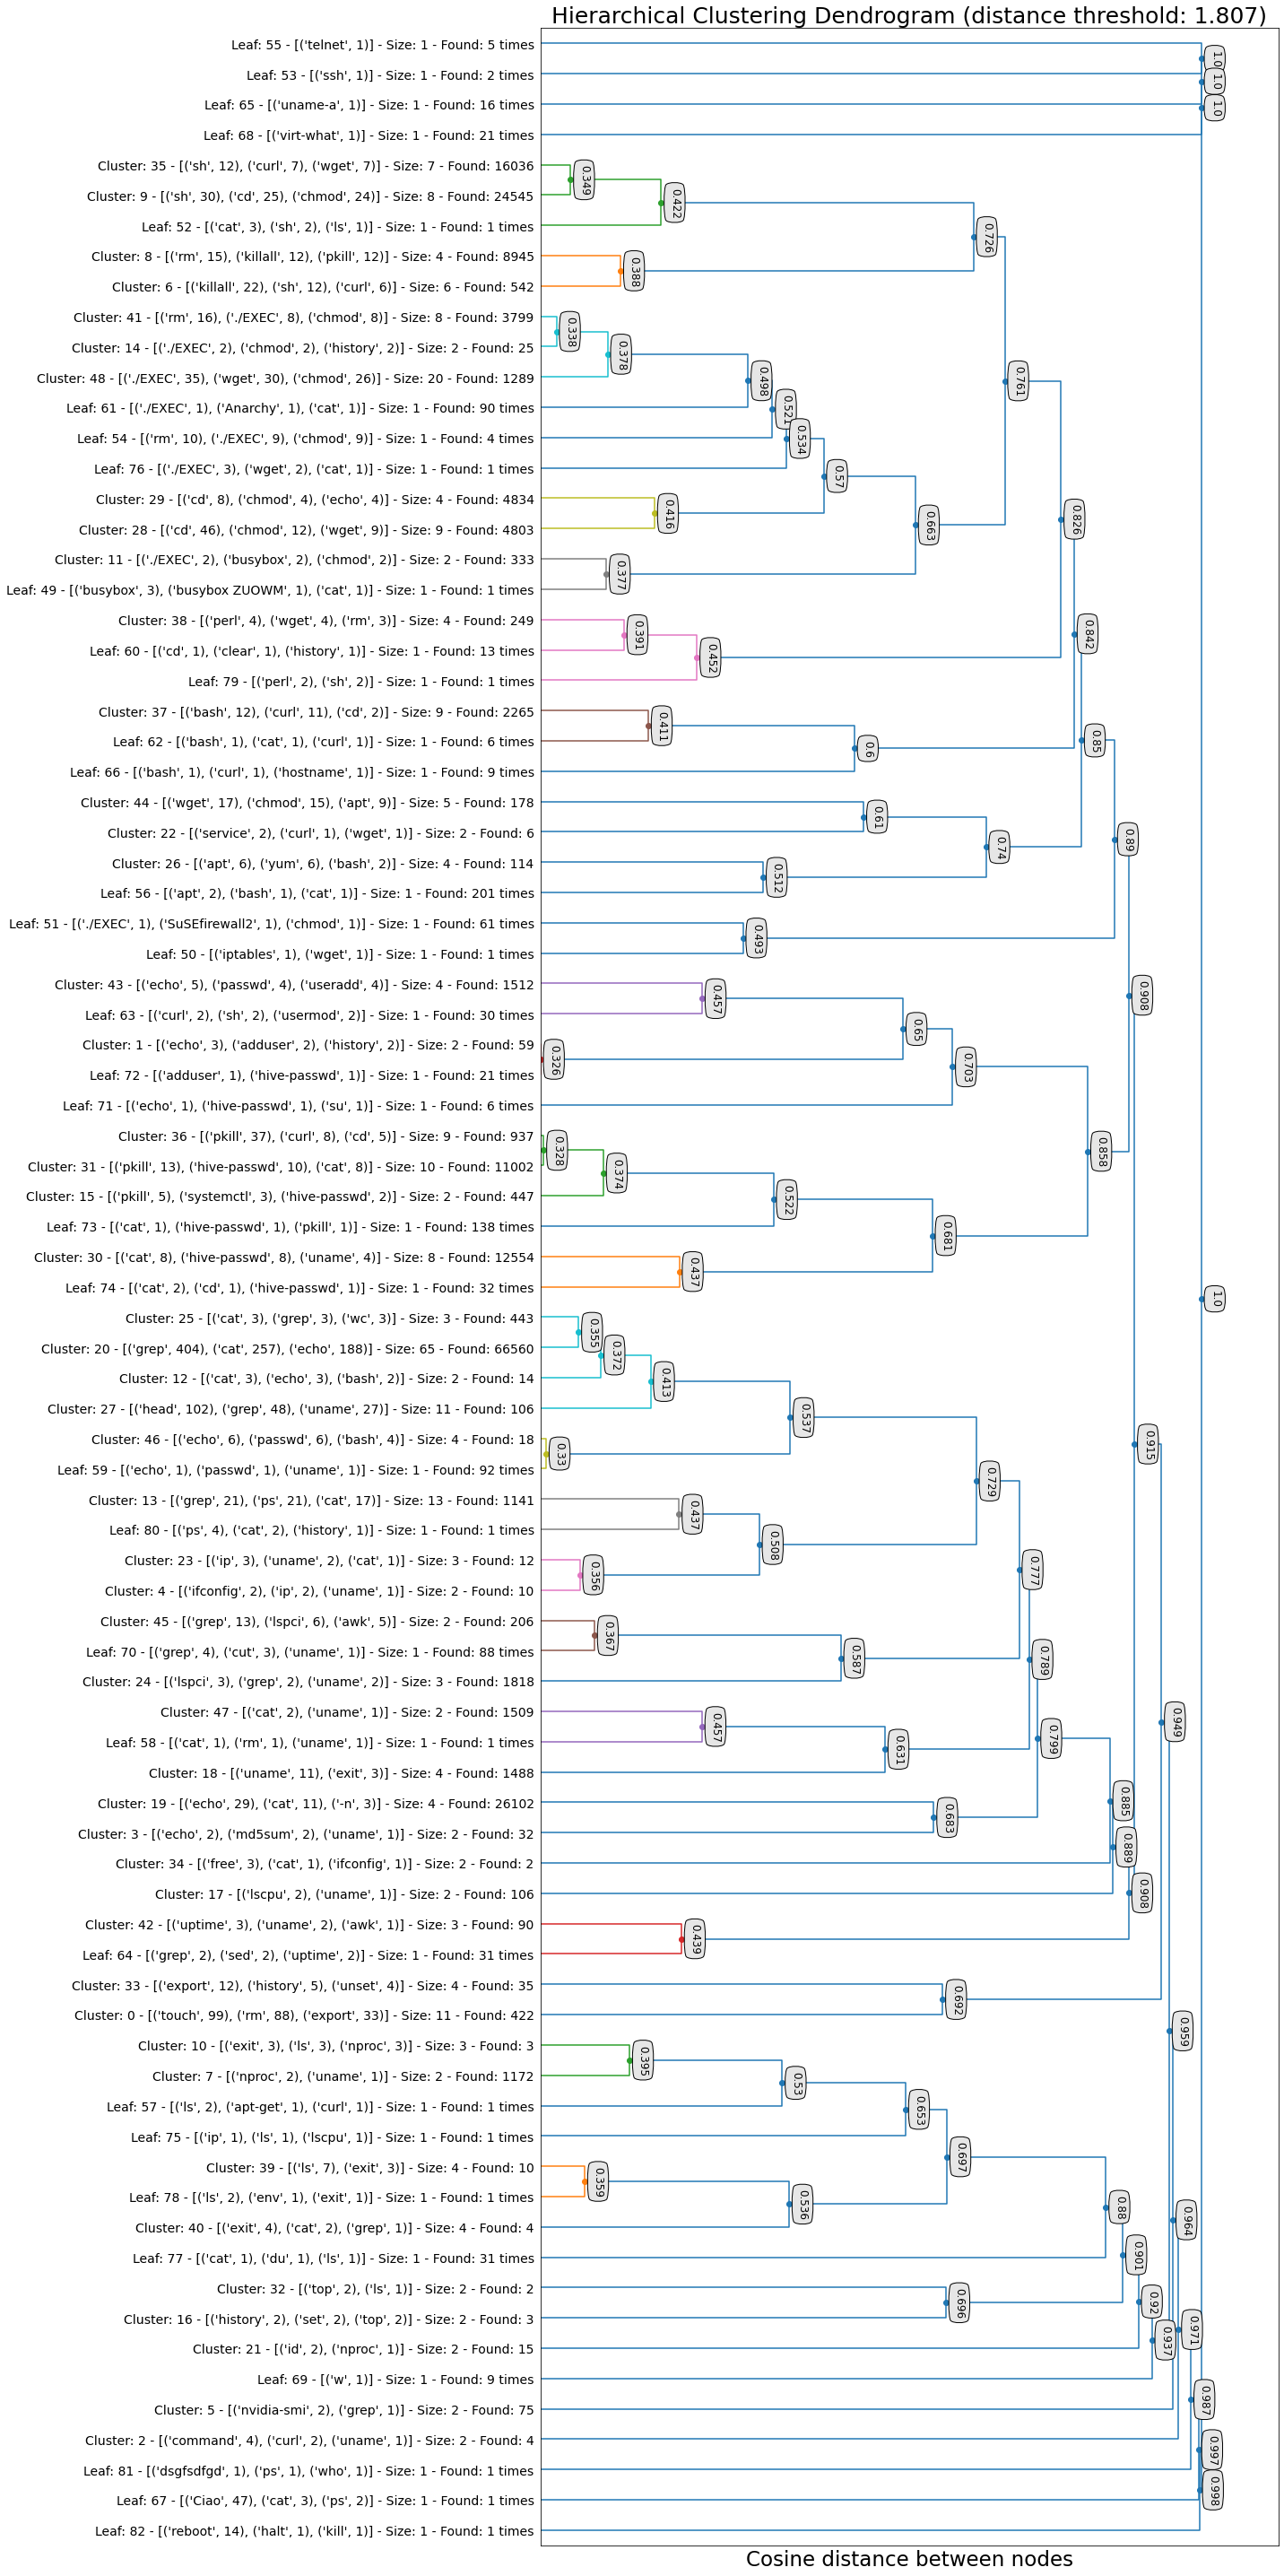

In [57]:
ordered_leaves = plot_dendrogram(linkage_matrix, best_cosine_threshold, look_up_table, clusters, sessions_per_cluster, occurrences_per_cluster, output_folder+sub_folders[1])

In [58]:
order_df = pd.DataFrame(ordered_leaves, columns = ["type_cluster","order_id","Cluster"])
order_df.head()

,type_cluster,order_id,Cluster
0,Leaf,82,55
1,Leaf,81,53
2,Leaf,80,65
3,Leaf,79,68
4,Cluster,78,35


## Ablation analysis:
#### Remove 1 command at the time and examine effects

In [59]:
with open("../Data/categories_of_commands.json") as f:
    dict_commands = json.load(f)

In [60]:
features = []
for key in dict_commands.keys():
    features += dict_commands[key]["commands"]

In [61]:
labels = ["Cluster"]
columns_to_select = labels + features
ablation_study = merged_numerosity_df[columns_to_select]
cluster_numerosities = ablation_study.groupby(["Cluster"]).size().reset_index(name = "|cluster|")
ablation_study.head()

,Cluster,cat,head,grep,echo,wc,arp,netstat,ip,ifconfig,...,dos2unix,screen,last,lastlog,w,who,pwd,whoami,which,crontab
0,49,0.094381,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.898931,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Plot reduced dendrogram (no leaves)

In [62]:
ablation_study_clusters_numerosities = pd.merge(ablation_study, cluster_numerosities, on="Cluster", how="inner")
ablation_study_clusters_numerosities = pd.merge(ablation_study_clusters_numerosities, order_df[order_df.columns[1:]], on="Cluster", how="inner").sort_values(by = "order_id", ascending = False)
ablation_study_clusters_numerosities_filtered = ablation_study_clusters_numerosities[ablation_study_clusters_numerosities["|cluster|"]!=1]
ablation_study_clusters_numerosities_filtered.reset_index(drop=True).head()

,Cluster,cat,head,grep,echo,wc,arp,netstat,ip,ifconfig,...,last,lastlog,w,who,pwd,whoami,which,crontab,|cluster|,order_id
0,35,0.188788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78
1,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78
2,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78
3,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78
4,35,0.195389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78


In [63]:
reduced_clusters, reduced_linkage_matrix, reduced_cosine_distances = best_run(ablation_study_clusters_numerosities_filtered[ablation_study_clusters_numerosities_filtered.columns[1:-2]].values, best_cosine_threshold)

We created 48 macro clusters
Those are grouping 294 leaves
0 leaves are missing
Therefore in the end we have 48 clusters


#### Create look-up table (rename clusters)

In [64]:
look_up_table = {}
for it, key in enumerate(reduced_clusters.keys()):
    look_up_table[key] = it

#### Obtain sequential identifiers

In [65]:
labels_sil = []
for cluster, list_elements in reduced_clusters.items():
    for el in list_elements:
        labels_sil.append((el, look_up_table[cluster]))
labels_sil.sort(key=lambda x: x[0])
labels_df_reduced = pd.DataFrame([el[1] for el in labels_sil], columns = ['Reduced_cluster'], index = ablation_study_clusters_numerosities_filtered.index) #Remember to add use the same indexes of normalized_sessions' ones

In [273]:
labels_df_reduced.head()

,Reduced_cluster
156,34
159,34
160,34
161,34
162,34


In [66]:
def reduced_plot_dendrogram(Z, distance_threshold, look_up_table):
    
    stopping_index = [index for index in range(Z.shape[0]) if Z[index][2] >= distance_threshold][0]

    print(f"\nWe stopped at index {stopping_index}; We miss {Z.shape[0]-stopping_index} merges")

    R = dendrogram(
                Z,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
                no_plot=True,
    )
    
    #plt.xlabel("Cosine distance between nodes", fontsize = fontsize + 3)
    
    temp = {R["leaves"][ii]:(look_up_table[R["leaves"][ii]]) for ii in range(len(R["leaves"]))} 
    global it
    it = len(R["leaves"])
    def llf(x):
        global it
        it -= 1
        #return "Cluster: {} - {}".format(look_up_table[x], it)
        return "{}".format(it)
        
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    results = dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
        leaf_font_size=20.,
        leaf_label_func=llf,
        show_contracted=True,  # to get a distribution impression in truncated branches  
        orientation = "right",
        color_threshold = 0
    )
    
    
    for i, d, c in zip(results['icoord'], results['dcoord'], results['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        plt.plot(y, x, 'o', c=c)
        plt.annotate(f"{round(y**2 /2,2)}", (y, x), xytext=(15, 0),
                             textcoords='offset points',
                             va='center', ha='center', rotation = 270, fontsize = fontsize-5, bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),)
    
    plt.xlim(distance_threshold)
    x_min, x_max = plt.gca().get_xlim()
    x_labels = [round(el,2) for el in np.arange(distance_threshold**2/2, x_max**2/2 + .05, .05)]
    plt.xticks([])
    print(f"Final number of leaves is {len(results['leaves'])}")
    #plt.title(f"Hierarchical Clustering Dendrogram (distance threshold: {distance_threshold++2/2:2.3f})", fontsize=fontsize+5)
    fig = plt.gcf()
    fig.set_size_inches(15, 20)
    plt.tight_layout()
        
    ordered_leaves = []
    for leaf_id, leaf in enumerate(results["leaves"]):
        ordered_leaves.append((leaf_id, look_up_table[leaf]))
    ordered_leaves.sort(key = lambda x: x[0], reverse = True)
    plt.savefig(output_folder+"Reduced_Dendrogram.pdf")
    return ordered_leaves


We stopped at index 246; We miss 47 merges
Final number of leaves is 48


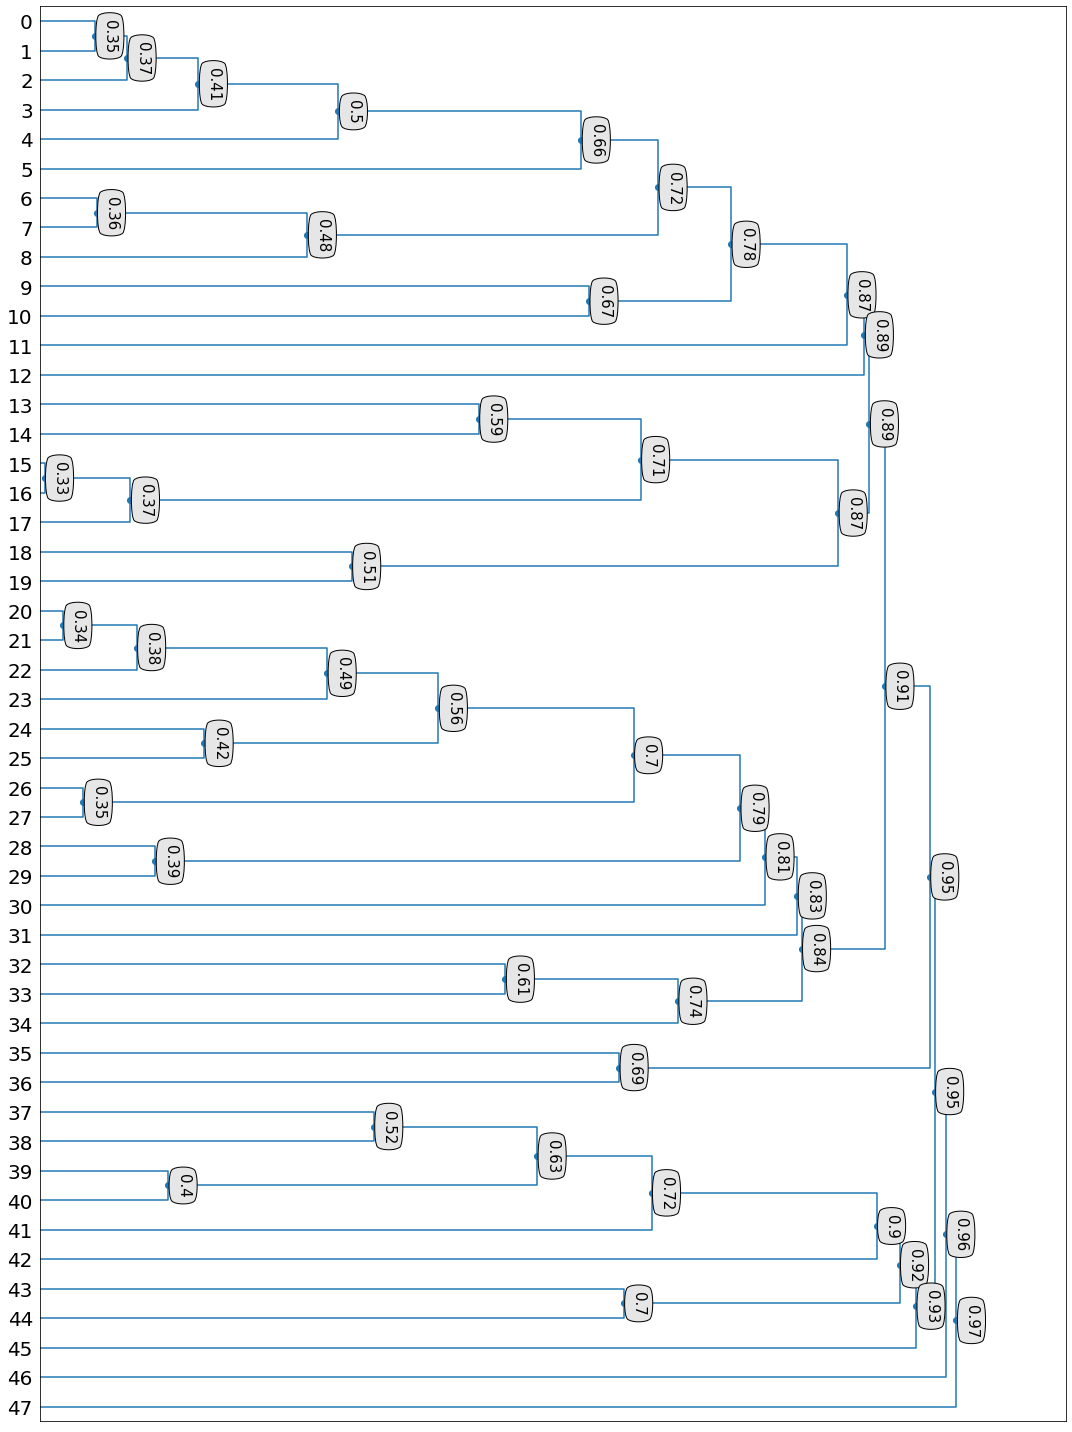

In [67]:
ordered_leaves = reduced_plot_dendrogram(reduced_linkage_matrix, best_cosine_threshold, look_up_table)

In [68]:
order_reduced_df = pd.DataFrame(ordered_leaves, columns = ["order_id_reduced","Reduced_cluster"])
order_reduced_df.head()

,order_id_reduced,Reduced_cluster
0,47,24
1,46,20
2,45,13
3,44,26
4,43,45


In [69]:
merged_ablation_df = pd.concat([ablation_study_clusters_numerosities_filtered, labels_df_reduced], axis = 1)
merged_ablation_df.head()

,Cluster,cat,head,grep,echo,wc,arp,netstat,ip,ifconfig,...,lastlog,w,who,pwd,whoami,which,crontab,|cluster|,order_id,Reduced_cluster
156,35,0.188788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78,34
159,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78,34
160,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78,34
161,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78,34
162,35,0.195389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,78,34


In [81]:
#6 - 36
merged_ablation_df[merged_ablation_df["Reduced_cluster"] == 36]["Cluster"]

25    37
26    37
33    37
32    37
31    37
30    37
29    37
28    37
27    37
Name: Cluster, dtype: int64

In [278]:
baricentrum_df = merged_ablation_df.groupby(["Cluster"])[features].mean()
baricentrum_df = pd.merge(baricentrum_df, merged_ablation_df[["Cluster", "Reduced_cluster"]].drop_duplicates(), on = "Cluster", how = "inner")
baricentrum_numerosities_df = pd.merge(baricentrum_df, cluster_numerosities, on="Cluster", how = "inner")
baricentrum_numerosities_df = pd.merge(baricentrum_numerosities_df, occurrences_per_cluster, on="Cluster", how = "inner")
baricentrum_numerosities_df.head()

,Cluster,cat,head,grep,echo,wc,arp,netstat,ip,ifconfig,...,lastlog,w,who,pwd,whoami,which,crontab,Reduced_cluster,|cluster|,occurrences
0,0,0.027465,0.0,0.008454,0.000000,0.0,0.0,0.0,0.014945,0.015537,...,0.0,0.0,0.0,0.022957,0.0,0.0,0.0,0,11,422
1,1,0.000000,0.0,0.000000,0.314508,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,2,59
2,2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2,2,4
3,3,0.000000,0.0,0.000000,0.320757,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3,2,32
4,4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.675022,0.701732,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4,2,10


In [279]:
features_reduced = baricentrum_numerosities_df[baricentrum_numerosities_df.columns[1:-2]]
others = baricentrum_numerosities_df[baricentrum_numerosities_df.columns[-3:]]

In [280]:
baricentrum_filtered = pd.merge(features_reduced.groupby("Reduced_cluster").mean(), others.groupby("Reduced_cluster").sum(), on = "Reduced_cluster", how = "inner").reset_index()
baricentrum_filtered.head()

,Reduced_cluster,cat,head,grep,echo,wc,arp,netstat,ip,ifconfig,...,last,lastlog,w,who,pwd,whoami,which,crontab,|cluster|,occurrences
0,0,0.027465,0.0,0.008454,0.000000,0.0,0.0,0.0,0.014945,0.015537,...,0.0,0.0,0.0,0.0,0.022957,0.0,0.0,0.0,11,422
1,1,0.000000,0.0,0.000000,0.314508,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2,59
2,2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2,4
3,3,0.000000,0.0,0.000000,0.320757,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2,32
4,4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.675022,0.701732,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2,10


In [318]:
baricentrum_filtered_ordered = pd.merge(baricentrum_filtered, order_reduced_df, on = "Reduced_cluster", how = "inner").sort_values(by = "order_id_reduced", ascending = False)
baricentrum_filtered_ordered["sequential_id"] = np.arange(baricentrum_filtered_ordered["Reduced_cluster"].shape[0])
baricentrum_filtered_ordered.head()

#indexes = list(baricentrum_filtered_ordered.apply(lambda line: f'{int(line["sequential_id"]):2d} - {int(line["Reduced_cluster"]):2d} ({int(line["|cluster|"]):2d} - {int(line["occurrences"]):5d})', axis = 1).values)
indexes = list(baricentrum_filtered_ordered.apply(lambda line: f'{int(line["sequential_id"]):2d} ({int(line["|cluster|"]):2d} - {int(line["occurrences"]):5d})', axis = 1).values)

In [282]:
baricentrum_filtered_ordered.head()

,Reduced_cluster,cat,head,grep,echo,wc,arp,netstat,ip,ifconfig,...,w,who,pwd,whoami,which,crontab,|cluster|,occurrences,order_id_reduced,sequential_id
24,24,0.431803,0.186122,0.530791,0.000000,0.595324,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,3,443,47,0
20,20,0.311431,0.162688,0.589433,0.261904,0.221072,0.0,0.0,0.0,0.0,...,0.122145,0.0,0.0,0.018454,0.134168,0.130181,65,66560,46,1
13,13,0.371881,0.154183,0.323068,0.434736,0.362346,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,2,14,45,2
26,26,0.109117,0.785317,0.329873,0.167807,0.113566,0.0,0.0,0.0,0.0,...,0.047642,0.0,0.0,0.000000,0.060345,0.048979,11,106,44,3
45,45,0.211242,0.059055,0.259668,0.408652,0.233646,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,4,18,43,4


In [308]:
ordered_columns = []
ordered_columns_dict = {}
ordered_groups = {}
for key in dict_commands.keys():
    print(f"Key: {key}")
    print(f"\t{dict_commands[key]}")
    filtered_commands = [command for command in dict_commands[key]["commands"] if command in baricentrum_filtered_ordered.columns[1:-22]]
    int_columns = baricentrum_filtered_ordered[filtered_commands]
    arg_maxs = {}
    for column in int_columns.columns:
        arg_maxs[column] = np.argmax(int_columns[column].values)
    #print(int_columns.shape, np.min(np.argmax(int_columns.values, axis = 0)))
    #print(f"\t\tThe mean per group is: {int_columns.mean().mean()}")
    #ordered_groups[key] = np.min(np.argmax(int_columns.values, axis = 0))
    ordered_groups[key] = np.mean(np.argmax(int_columns.values, axis = 0))
    ordered_columns_dict[key] = sorted(arg_maxs, key=arg_maxs.get, reverse=False)
    ordered_columns += sorted(arg_maxs, key=arg_maxs.get, reverse=False)

Key: Capture info from file
	{'commands': ['cat', 'head', 'grep', 'echo', 'wc'], 'id': 1}
Key: Network configuration
	{'commands': ['arp', 'netstat', 'ip', 'ifconfig'], 'id': 7}
Key: Server configuration
	{'commands': ['lspci', 'lscpu'], 'id': 7}
Key: Process
	{'commands': ['free', 'ps', 'pkill', 'killall'], 'id': 7}
Key: user/password manipulation, privilege scalation
	{'commands': ['su', 'chpasswd', 'hive-passwd', 'passwd', 'useradd', 'usermod', 'adduser'], 'id': 2}
Key: File system manipulation
	{'commands': ['mv', 'unrar', 'unzip', 'tar', 'mkdir', 'chmod', './EXEC', 'history', 'cd', 'rm'], 'id': 3}
Key: Terminal
	{'commands': ['bash', 'perl', 'sh', 'busybox'], 'id': 4}
Key: File download & System update & unzip
	{'commands': ['curl', 'wget', 'apt', 'ftpget', 'tftp', 'yum'], 'id': 5}
Key: variable, services, process etc
	{'commands': ['set', 'export', 'unset', 'service', 'systemctl'], 'id': 8}
Key: Others
	{'commands': ['touch', 'exit', 'ls', 'nproc', 'uname', 'uptime', 'top', 'id',

In [310]:
ordered_columns_2 = []
for key in sorted(ordered_groups, key=ordered_groups.get, reverse=False): 
    ordered_columns_2+=ordered_columns_dict[key]

In [311]:
int_columns = baricentrum_filtered_ordered[baricentrum_filtered_ordered.columns[1:-22]]
#int_columns.shape
#int_columns.mean(axis = 0).sort_values(ascending = False).index
arg_maxs = {}
for column in int_columns.columns:
    arg_maxs[column] = np.argmax(int_columns[column].values)

In [312]:
#new_cols = list(baricentrum_filtered_ordered.columns[:1].values) + sorted(arg_maxs, key=arg_maxs.get, reverse=False) + list(baricentrum_filtered_ordered.columns[-22:].values)
new_cols = list(baricentrum_filtered_ordered.columns[:1].values) + ordered_columns_2 + list(baricentrum_filtered_ordered.columns[-22:].values)
baricentrum_filtered_alternative_ordered = baricentrum_filtered_ordered[new_cols]

In [313]:
new_cols = list(baricentrum_filtered_ordered.columns[:1].values) + ordered_columns + list(baricentrum_filtered_ordered.columns[-22:].values)
baricentrum_filtered_ordered = baricentrum_filtered_ordered[new_cols]

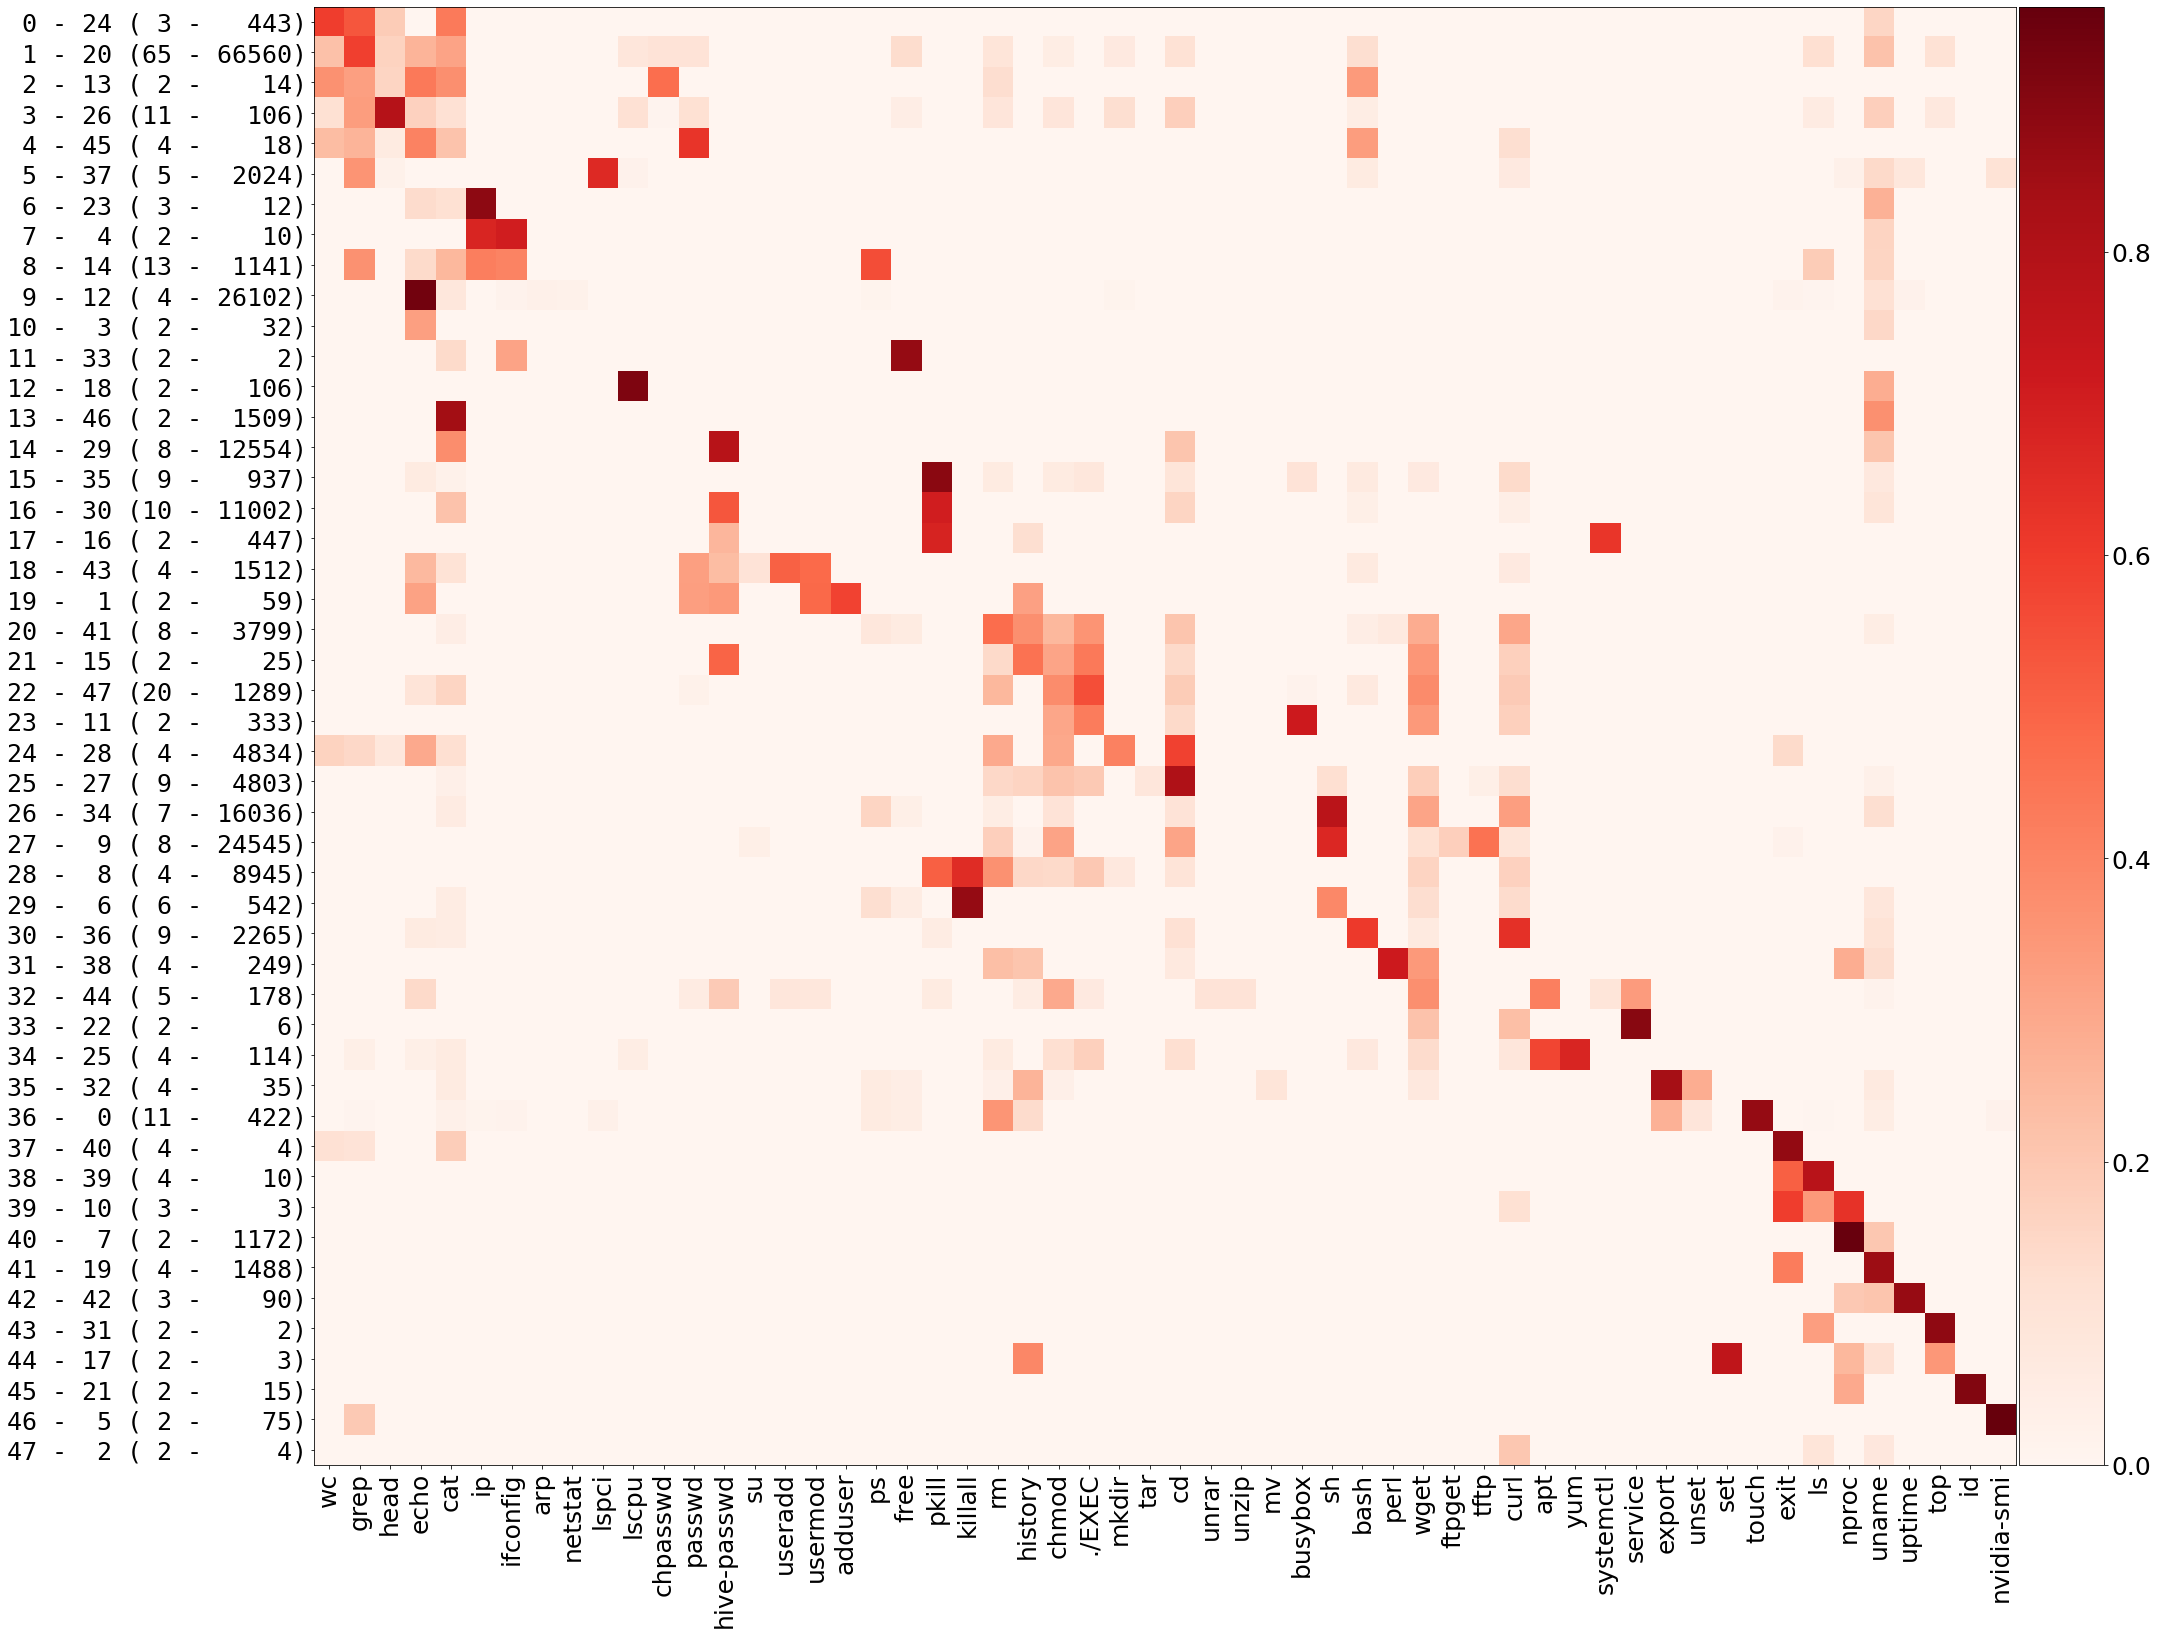

In [317]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, figsize=(30,25))
fontsize = 25

to_plot = baricentrum_filtered_alternative_ordered[baricentrum_filtered_alternative_ordered.columns[1:-22]]

im = axs.imshow(to_plot, cmap = "Reds")

"""
def rect(pos):
    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=.2)
    plt.gca().add_patch(r)

coords = []
for x in range(to_plot.shape[1]):
    for y in range(to_plot.shape[0]):
        coords.append(np.array([x,y]))

for pos in coords:
    rect(pos)
"""
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
#axs.set_title(f"Cluster Baricentra", fontsize = fontsize + 5)
#axs.set_ylabel("Cluster (clusters's sizes - sessions per clusters)", fontsize = fontsize + 3)
#axs.set_xlabel('Feature - Command', fontsize = fontsize + 3)

#axs.set_xticks(range(len(baricentrum_filtered.columns[1:-3])), np.arange(len(baricentrum_filtered.columns[1:-3])), fontsize = fontsize)

axs.set_xticks(range(len(baricentrum_filtered_alternative_ordered.columns[1:-22])), baricentrum_filtered_alternative_ordered.columns[1:-22], fontsize = fontsize+5)
axs.set_yticks(range(len(baricentrum_filtered_alternative_ordered.index)), indexes, fontsize = fontsize+5)
for label in axs.get_yticklabels():
    label.set_fontproperties("monospace")
#axs.set_yticks(range(len(baricentrum_filtered.index)), np.arange(len(baricentrum_filtered.index)), fontsize = fontsize)
axs.yaxis.labelpad = 40
axs.xaxis.labelpad = 80

axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 90)      
   
plt.tight_layout()
plt.savefig(output_folder+"Tfidf_diagonal_heatmap.pdf")
plt.show()

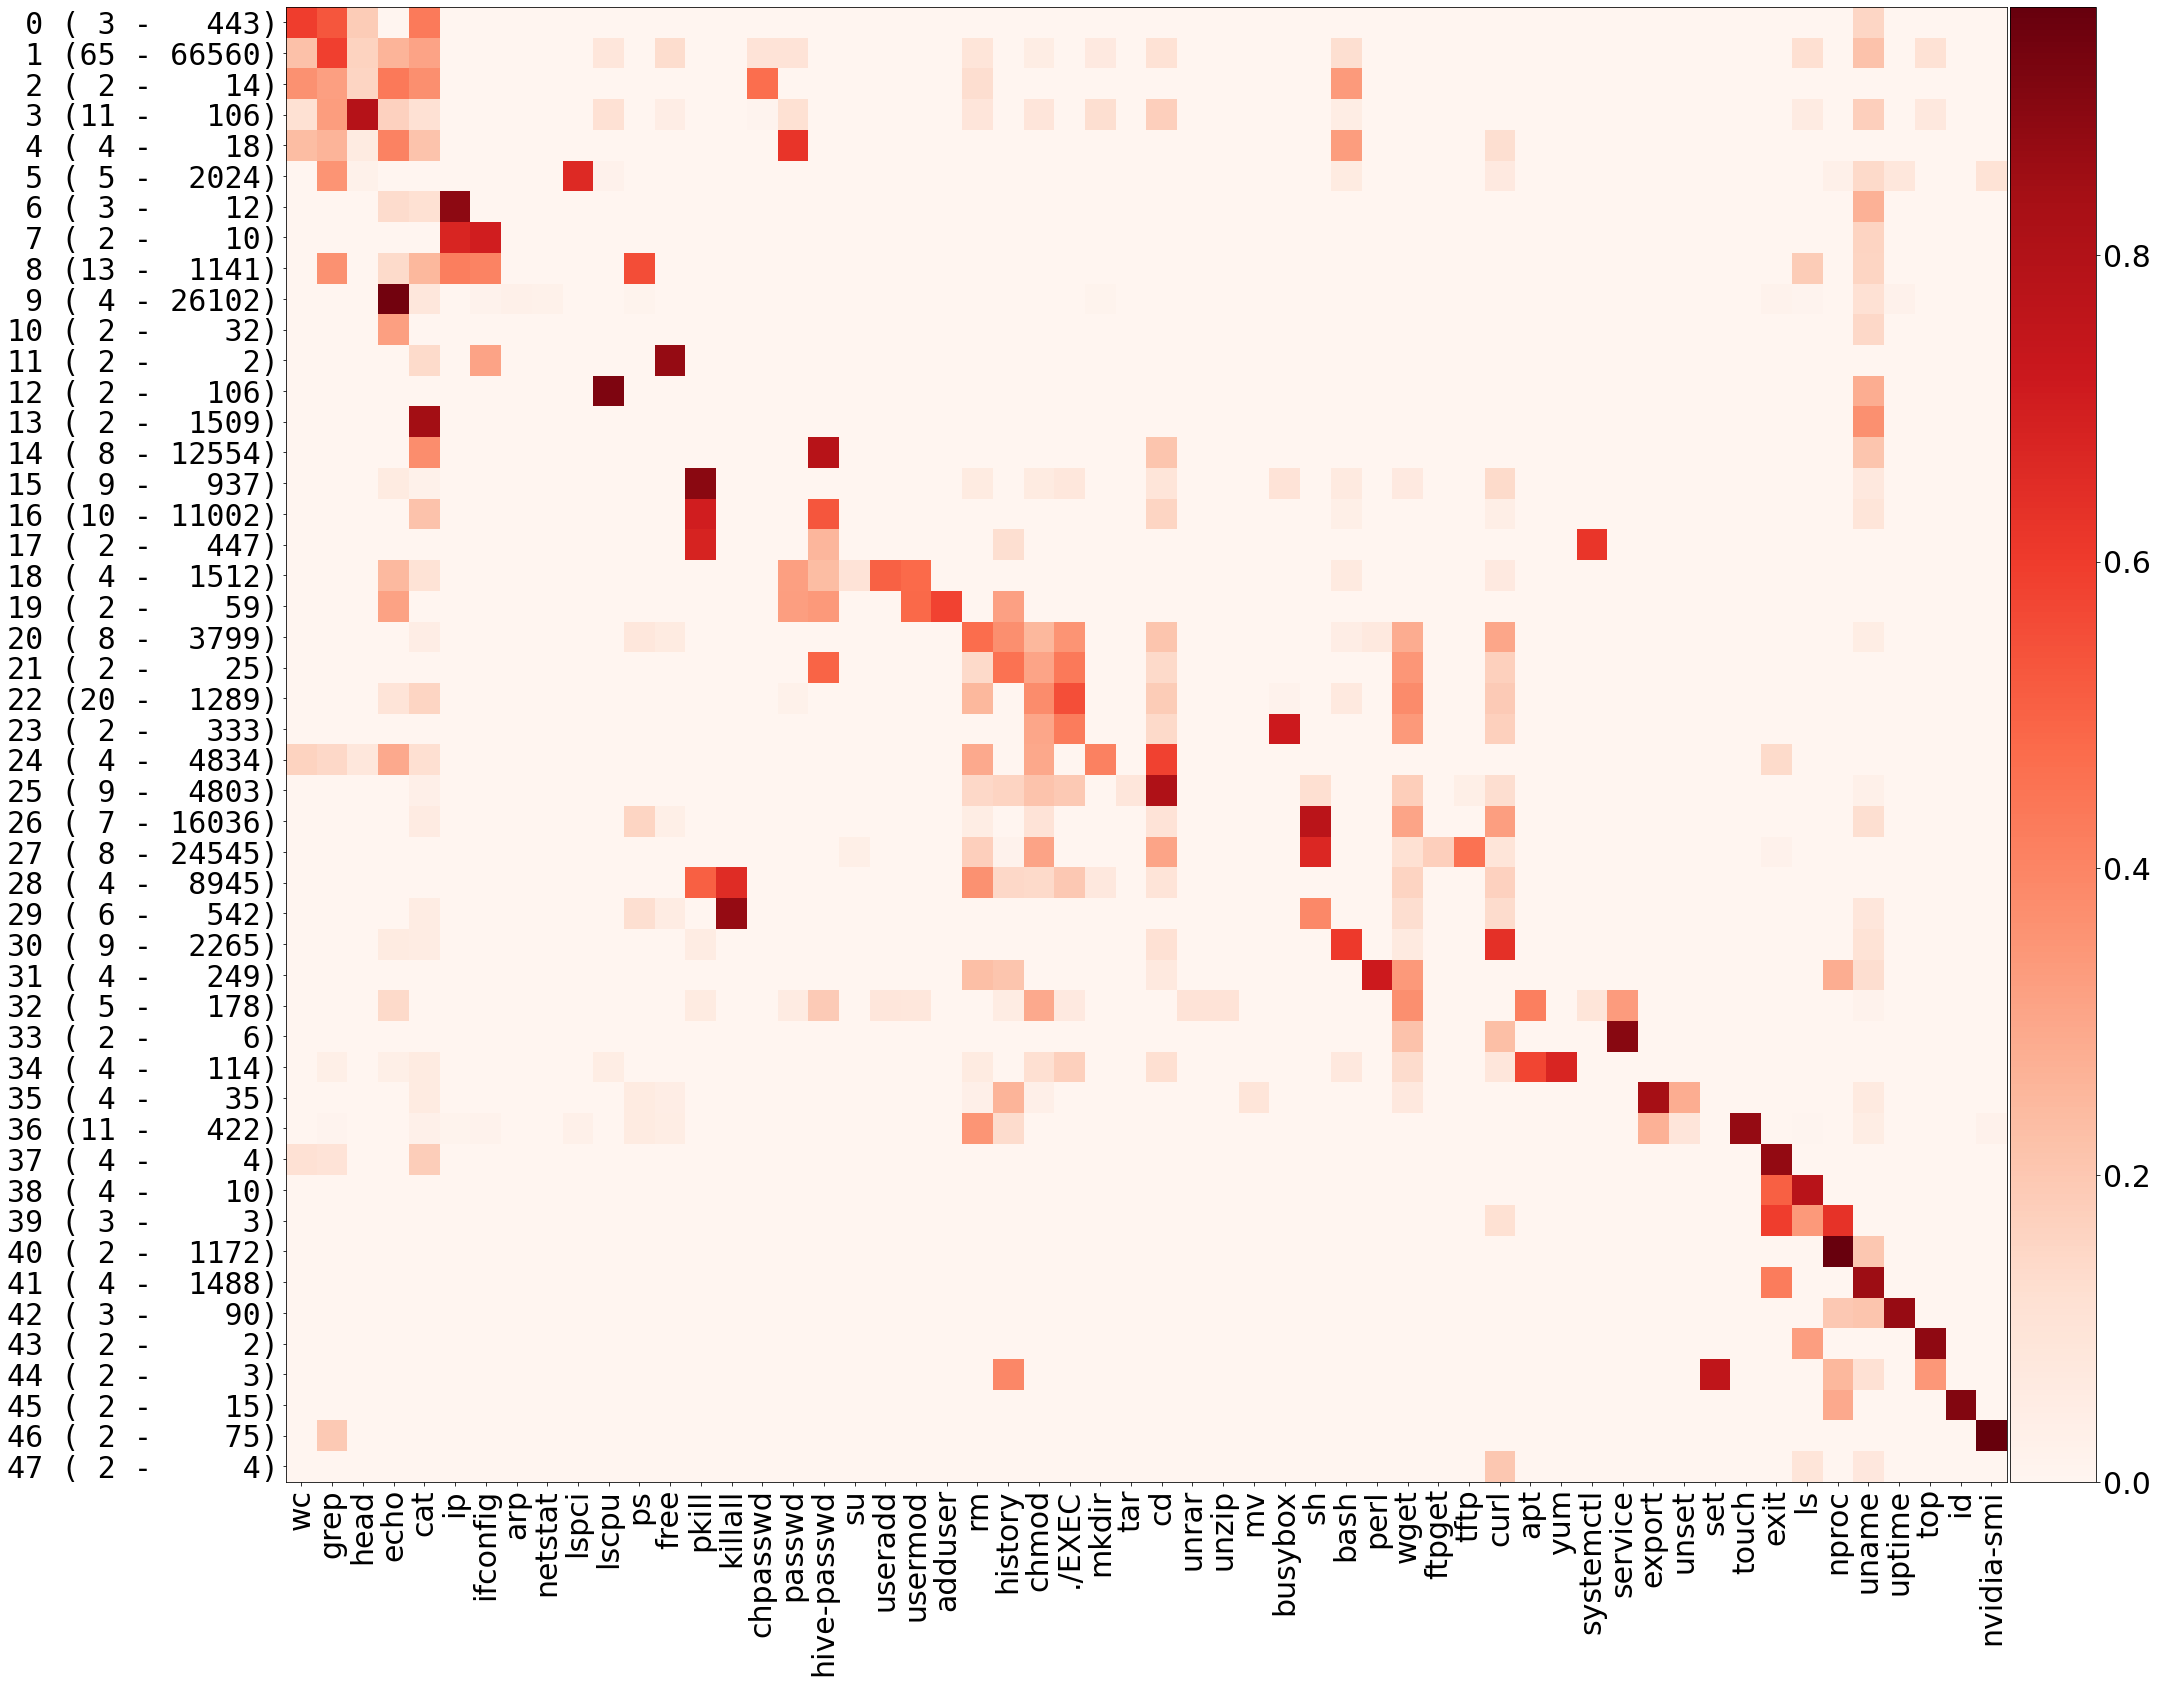

In [315]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, figsize=(30,25))
fontsize = 30

to_plot = baricentrum_filtered_ordered[baricentrum_filtered_ordered.columns[1:-22]]

im = axs.imshow(to_plot, cmap = "Reds")
"""
def rect(pos):
    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=.2)
    plt.gca().add_patch(r)

coords = []
for x in range(to_plot.shape[1]):
    for y in range(to_plot.shape[0]):
        coords.append(np.array([x,y]))

for pos in coords:
    rect(pos)
"""
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
#axs.set_title(f"Cluster Baricentra", fontsize = fontsize + 5)
#axs.set_ylabel("Cluster (clusters's sizes - sessions per clusters)", fontsize = fontsize + 3)
#axs.set_xlabel('Feature - Command', fontsize = fontsize + 3)

#axs.set_xticks(range(len(baricentrum_filtered.columns[1:-3])), np.arange(len(baricentrum_filtered.columns[1:-3])), fontsize = fontsize)

axs.set_xticks(range(len(baricentrum_filtered_ordered.columns[1:-22])), baricentrum_filtered_ordered.columns[1:-22], fontsize = fontsize+5)
axs.set_yticks(range(len(baricentrum_filtered_ordered.index)), indexes, fontsize = fontsize+5)
for label in axs.get_yticklabels():
    label.set_fontproperties("monospace")
#axs.set_yticks(range(len(baricentrum_filtered.index)), np.arange(len(baricentrum_filtered.index)), fontsize = fontsize)
axs.yaxis.labelpad = 40
axs.xaxis.labelpad = 80

axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 90)      
   
plt.tight_layout()
plt.savefig(output_folder+"Tfidf_heatmap.pdf")
plt.show()

## Now, before saving, we want to add a final ordering: analysing cluster per cluster, we want to understand how the cluster was created (when each item was added to the cluster) 

In [ ]:
clusters = merged_numerosity_df["Cluster"].drop_duplicates().values
order_per_cluster = []
for cluster_under_study in clusters:
    #print(f"Under analysis: {cluster_under_study}", end = "\t")
    merged_numerosity_df_cluster_desired = merged_numerosity_df[merged_numerosity_df['Cluster']  == cluster_under_study].reset_index()
    if merged_numerosity_df_cluster_desired.shape[0] == 1:
        #print("Leaf")
        order_per_cluster.append([cluster_under_study, merged_numerosity_df_cluster_desired["normalized_sessions"].iloc[0],0])
    else:
        #print("Cluster")

        new_linkage_matrix = hierarchy.linkage(merged_numerosity_df_cluster_desired[merged_numerosity_df_cluster_desired.columns[5:-1]].values, method='average', metric='cosine') 

        order_leaves = 0
        for row in new_linkage_matrix:
            for i in [0,1]:
                if int(row[i]) < (new_linkage_matrix.shape[0]+1):
                    if str(cluster_under_study) == "21":
                        print(f"{i}) Appending element {merged_numerosity_df_cluster_desired['normalized_sessions'].iloc[int(row[i])]} with id {order_leaves}")
                    order_per_cluster.append([cluster_under_study, merged_numerosity_df_cluster_desired["normalized_sessions"].iloc[int(row[i])],order_leaves])
                    order_leaves += 1

        assert order_leaves == (new_linkage_matrix.shape[0] + 1), "Some leaves was not considered!"

In [ ]:
df_order_per_cluster = pd.DataFrame(order_per_cluster, columns =['Cluster', "normalized_sessions", "order_per_cluster"])
df_order_per_cluster.head()

#### Save info about Tfidf representation

First add info of clusters order > same as dendrogram

In [ ]:
joined_merged_numerosity_df = pd.merge(merged_numerosity_df, order_df, on = ["Cluster"], how = "inner")

Then the one about order per cluster

In [ ]:
final_joined_merged_numerosity_df = pd.merge(joined_merged_numerosity_df, df_order_per_cluster, on = ["Cluster", "normalized_sessions"], how = "inner")
final_joined_merged_numerosity_df.head()

In [ ]:
#Reorder columns 
columns = final_joined_merged_numerosity_df.columns.tolist()
final_joined_merged_numerosity_df = final_joined_merged_numerosity_df[columns[:5]+columns[-4:]+columns[5:-4]]
sorted_merged = final_joined_merged_numerosity_df.sort_values(by=['order_id', 'order_per_cluster'], ascending = [False, True])
sorted_merged.head()

In [ ]:
#To CSV
sorted_merged.to_csv(output_folder+sub_folders[0]+f"numerical_representation_sorted.csv", index = False)
final_joined_merged_numerosity_df.to_csv(output_folder+sub_folders[0]+f"numerical_representation.csv", index = False)
#To Excel
sorted_merged.to_excel(output_folder+sub_folders[0]+f"numerical_representation_sorted.xlsx", index = False) 
final_joined_merged_numerosity_df.to_excel(output_folder+sub_folders[0]+f"numerical_representation.xlsx", index = False) 

In [ ]:
df_order_per_cluster.head()

#### Save also complete lists of session with associated clusters with "same rules"

In [ ]:
join_session_cluster = pd.merge(normalized_sessions_and_occurrences, merged_numerosity_df[["normalized_sessions", "Cluster", "Distinct_types_per_clusters", "commands_per_session"]], on = ["normalized_sessions"], how="inner")
#First merge
join_session_cluster = pd.merge(join_session_cluster, order_df, on = ["Cluster"], how = "inner")
join_session_cluster.head()
#Second merge
join_session_cluster = pd.merge(join_session_cluster, df_order_per_cluster, on = ["Cluster", "normalized_sessions"], how = "inner")
#Sorting
sorted_join_session_cluster = join_session_cluster.sort_values(by=['order_id', 'order_per_cluster'], ascending = [False, True])
sorted_join_session_cluster.head()

In [ ]:
#To CSV
join_session_cluster.to_csv(output_folder+sub_folders[0]+f"Clusters_and_complete_sessions.csv", index = False)
sorted_join_session_cluster.to_csv(output_folder+sub_folders[0]+f"Sorted_clusters_and_complete_sessions.csv", index = False)
#To Excel
join_session_cluster.to_excel(output_folder+sub_folders[0]+f"Clusters_and_complete_sessions.xlsx", index = False)
sorted_join_session_cluster.to_excel(output_folder+sub_folders[0]+f"Sorted_clusters_and_complete_sessions.xlsx", index = False)